In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

import wget

import matplotlib.pyplot as plt
import librosa.display

import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder  # OBBLIGATORIO DA USARE
from tensorflow.keras.utils import to_categorical  # OBBLIGATORIO DA USARE
from io import TextIOWrapper

# from tqdm.notebook import tqdm
from tqdm import tqdm
import requests


from sklearn.metrics import balanced_accuracy_score


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
# !wget -nc -O IDMT_Traffic.zip "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
# !unzip -n IDMT_Traffic.zip > /dev/null

In [ ]:
def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

In [ ]:
def extract_zip_if_needed(zip_path, extract_to=None):
    """
    Estrae il file ZIP se la cartella di destinazione non esiste già.
    
    Args:
        zip_path (str): Percorso al file ZIP
        extract_to (str, optional): Cartella dove estrarre i file. Se None, usa il nome del file ZIP.
    
    Returns:
        str: Percorso alla cartella estratta
    """
    
    # Se la directory di estrazione non è specificata, usa il nome del file ZIP
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]
    
    # Controlla se la directory di estrazione esiste già
    if os.path.exists(extract_to) and os.path.isdir(extract_to):
        print(f"La directory '{extract_to}' esiste già, l'estrazione verrà saltata.")
        return extract_to
    
    # Estrai lo ZIP se esiste
    if os.path.exists(zip_path):
        print(f"Estrazione di '{zip_path}' in '{extract_to}'...")
        
        # Ottieni la lista dei file nello ZIP per la progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)
        
        # Estrai i file con progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            os.makedirs(extract_to, exist_ok=True)
            for file in tqdm(file_list, desc="Estrazione files", total=total_files):
                zip_ref.extract(file, extract_to)
        
        print(f"Estrazione completata in '{extract_to}'")
    else:
        raise FileNotFoundError(f"Il file ZIP '{zip_path}' non esiste.")
    
    return extract_to

In [ ]:
# Percorso assoluto del file ZIP
# ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip" # di Stefano
ZIP_PATH = "IDMT_Traffic.zip"
# AUDIO_DIR = "IDMT_Traffic/audio/"
# ANN_DIR = "IDMT_Traffic/annotation/idmt_traffic_all.txt"

# Download file if it doesn't exist
if not os.path.exists(ZIP_PATH):
    url = "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
    print(f"Downloading {ZIP_PATH}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(ZIP_PATH, 'wb') as file:
        with tqdm(
                desc=ZIP_PATH,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    print("Download complete!")
else:
    print(f"File {ZIP_PATH} already exists, skipping download.")


# Estrai lo ZIP se necessario
extracted_dir = extract_zip_if_needed(ZIP_PATH)

AUDIO_DIR_PATH = os.path.join(extracted_dir, "IDMT_Traffic/audio/")
ANN_FILE_PATH = os.path.join(extracted_dir, "IDMT_Traffic/annotation/idmt_traffic_all.txt")

all_audio_files = [os.path.join(AUDIO_DIR_PATH, f) for f in os.listdir(AUDIO_DIR_PATH) if f.endswith('.wav')]
print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")

# Leggi il file di annotazione
# df_dataset = pd.read_csv(ANN_FILE_PATH, sep="\t", header=None)
df_dataset = import_idmt_traffic_dataset(ANN_FILE_PATH)
vehicle = df_dataset["vehicle"]
direction = df_dataset["source_direction"]
print(np.unique(vehicle))
print(np.unique(direction))


# LABEL ENCODING
'''
le = LabelEncoder() #OBBLIGATORIO DA USARE?
labels_encoded_vehicle= le.fit_transform(vehicle) #OBBLIGATORIO DA USARE?
labels_cat_vehicles = to_categorical(labels_encoded_vehicle) #OBBLIGATORIO DA USARE?

labels_encoded_direction= le.fit_transform(direction) #OBBLIGATORIO DA USARE?
labels_cat_direction = to_categorical(labels_encoded_direction) #OBBLIGATORIO DA USARE?
'''
# Use separate encoders for different label types
le_vehicle = LabelEncoder()
labels_encoded_vehicle = le_vehicle.fit_transform(vehicle)
labels_cat_vehicles = to_categorical(labels_encoded_vehicle)

le_direction = LabelEncoder()
labels_encoded_direction = le_direction.fit_transform(direction)
labels_cat_direction = to_categorical(labels_encoded_direction)

File IDMT_Traffic.zip already exists, skipping download.
La directory 'IDMT_Traffic' esiste già, l'estrazione verrà saltata.

Numero totale di file audio trovati: 17506
['B' 'C' 'M' 'None' 'T']
['L' 'None' 'R']


In [9]:
# Normalization and Padding

spectograms = []
fixed_length = None

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

# Process files directly from the filesystem instead of the ZIP
for audio_path in all_audio_files[:]:
    y, sr = librosa.load(audio_path, sr=None)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    if fixed_length is None:
        fixed_length = mel_spectrogram_db.shape[1]
    
    # Padding o troncamento
    if mel_spectrogram_db.shape[1] < fixed_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                    ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                    mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
    
    # Normalizzazione
    mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)
    
    spectograms.append(mel_spectrogram_db)       



spectograms = np.array(spectograms)
spectograms = spectograms / np.max(np.abs(spectograms))
input_shape = spectograms.shape[1:]
print(spectograms.shape)
print(input_shape)

(17506, 128, 188)
(128, 188)


In [10]:
''' NON USATA '''
# Data Augmentation 

#augmented_versions = []

def random_window(y, sr, window_duration=2.0):
    """Estrae una finestra casuale di durata fissa dal segnale audio."""
    window_length = int(window_duration * sr)
    if len(y) <= window_length:
        return np.pad(y, (0, window_length - len(y)), mode='constant')
    else:
        start = np.random.randint(0, len(y) - window_length)
        return y[start:start + window_length]


# Esempio di una funzione di augmentazione
def augment_audio(y, sr):
    versions = []

    # Applica Random Window di 2 secondi
    y_crop = random_window(y, sr, window_duration=2.0)

    # Originale (crocato)
    versions.append(y_crop)

    # Pitch shift
    versions.append(librosa.effects.pitch_shift(y_crop, sr=sr, n_steps=2))

    # Time stretch
    y_stretched = librosa.effects.time_stretch(y_crop, rate=1.2)
    if len(y_stretched) > len(y_crop):
        y_stretched = y_stretched[:len(y_crop)]
    else:
        y_stretched = np.pad(y_stretched, (0, len(y_crop) - len(y_stretched)), mode='constant')
    versions.append(y_stretched)

    # Rumore
    versions.append(add_noise(y_crop, snr_db=10))

    # Impulse response (opzionale)
    # ir, _ = librosa.load('impulse_response.wav', sr=sr)
    # ir = ir / np.sqrt(np.sum(ir**2))
    # y_reverb = fftconvolve(y_crop, ir, mode='full')[:len(y_crop)]
    # versions.append(y_reverb)

    return versions

In [11]:
# Dataset Split corretto per multi-output (due tipi di etichette)

# Reshape per CNN (aggiunge canale)
spectograms_reshaped = spectograms.reshape(spectograms.shape[0], spectograms.shape[1], spectograms.shape[2], 1)

# 1. Primo split: Train (70%) e Temporary (30%)
X_train, X_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectograms_reshaped, 
    labels_cat_vehicles, 
    labels_cat_direction,
    test_size=0.30,           # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp, 
    y_temp_vehicle, 
    y_temp_direction,
    test_size=0.50,           # 15% validation, 15% test (metà del 30% temporary)
    random_state=42,
    shuffle=True
)

print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifica dimensioni input per il modello
print(f"Dimensione input: {X_train.shape[1:]}")

Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni
Dimensione input: (128, 188, 1)



Number of audio files per vehicle class (Full Dataset):
vehicle
None    8144
C       7804
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Training Set):
B         68
C       5448
M        304
None    5705
T        729
Name: count, dtype: int64

Number of audio files per vehicle class (Validation Set):
B         16
C       1179
M         68
None    1226
T        137
Name: count, dtype: int64

Number of audio files per vehicle class (Test Set):
B         22
C       1177
M         58
None    1213
T        156
Name: count, dtype: int64


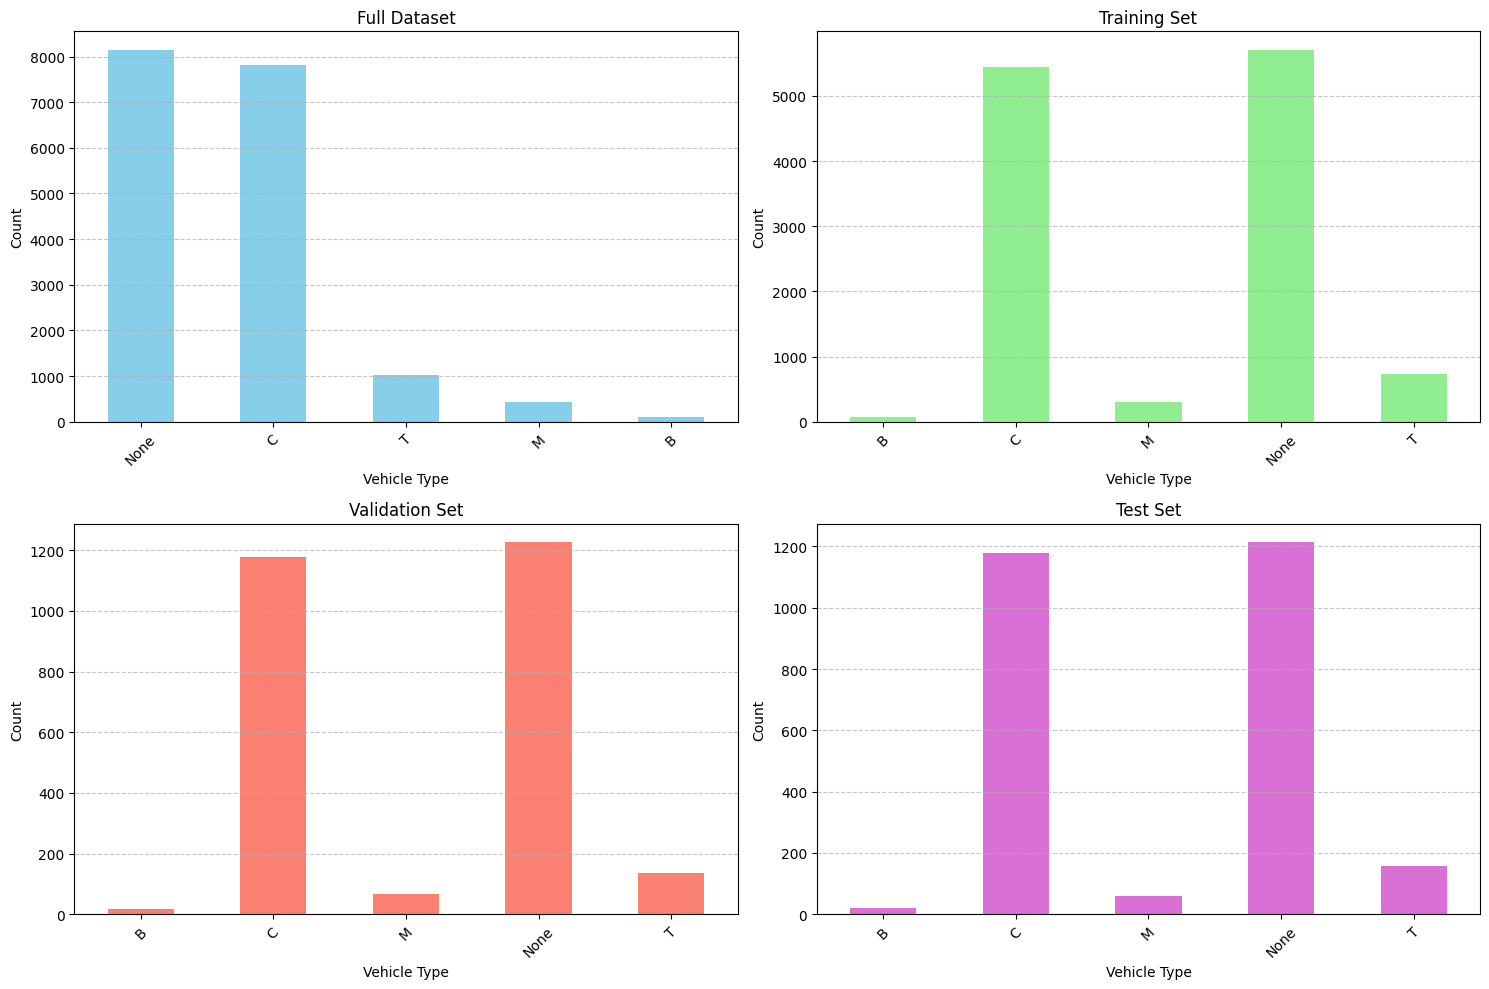

<Figure size 1200x600 with 0 Axes>

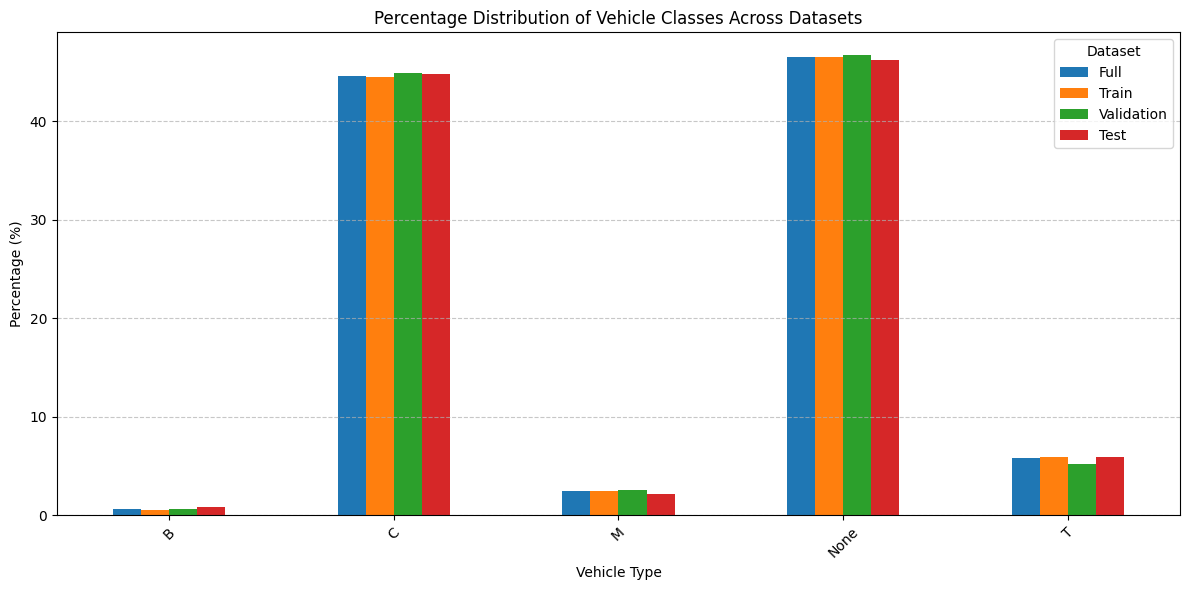

In [31]:
# 1. Count in the full dataset
vehicle_counts_full = df_dataset["vehicle"].value_counts()
print("\nNumber of audio files per vehicle class (Full Dataset):")
print(vehicle_counts_full)

# 2. Count in the split datasets
# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(y_train_vehicle, axis=1)
y_val_indices = np.argmax(y_val_vehicle, axis=1)
y_test_indices = np.argmax(y_test_vehicle, axis=1)

# Get the class names in the correct order
class_names = le_vehicle.classes_

# Create DataFrames for counting
train_counts = pd.Series(y_train_indices).map(lambda idx: class_names[idx]).value_counts()
val_counts = pd.Series(y_val_indices).map(lambda idx: class_names[idx]).value_counts()
test_counts = pd.Series(y_test_indices).map(lambda idx: class_names[idx]).value_counts()

# Ensure all classes are present in each count (even if zero)
for counts in [train_counts, val_counts, test_counts]:
    for class_name in class_names:
        if class_name not in counts:
            counts[class_name] = 0
    counts.sort_index(inplace=True)

# Print counts for each split
print("\nNumber of audio files per vehicle class (Training Set):")
print(train_counts)
print("\nNumber of audio files per vehicle class (Validation Set):")
print(val_counts)
print("\nNumber of audio files per vehicle class (Test Set):")
print(test_counts)

# Visualize the class distribution
plt.figure(figsize=(15, 10))

# Full dataset
plt.subplot(2, 2, 1)
vehicle_counts_full.plot(kind='bar', color='skyblue')
plt.title('Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Training set
plt.subplot(2, 2, 2)
train_counts.plot(kind='bar', color='lightgreen')
plt.title('Training Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Validation set
plt.subplot(2, 2, 3)
val_counts.plot(kind='bar', color='salmon')
plt.title('Validation Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Test set
plt.subplot(2, 2, 4)
test_counts.plot(kind='bar', color='orchid')
plt.title('Test Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a percentage distribution chart for comparison
plt.figure(figsize=(12, 6))

# Create a DataFrame with all counts for easy comparison
counts_df = pd.DataFrame({
    'Full': vehicle_counts_full / vehicle_counts_full.sum() * 100,
    'Train': train_counts / train_counts.sum() * 100,
    'Validation': val_counts / val_counts.sum() * 100,
    'Test': test_counts / test_counts.sum() * 100
})

# Plot percentage distribution
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage Distribution of Vehicle Classes Across Datasets')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [ ]:
def plot_and_evaluate_single_output_model(history, y_true, y_pred, class_names=None):
    """
    Visualizza le metriche di addestramento e genera il classification report
    per un modello con singolo output usando predizioni pre-calcolate.
    
    Args:
        history: Oggetto history restituito da model.fit()
        y_true: Label vere (indici di classe, non one-hot encoded)
        y_pred: Predizioni del modello (indici di classe, non one-hot encoded)
        class_names: Lista con i nomi delle classi (opzionale)
    """
    
    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(12, 5))
    
    # Grafico per l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Grafico per la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Trova e stampa la migliore accuracy
    best_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_acc) + 1
    
    print(f"Miglior accuracy: {best_acc:.4f} (epoch {best_epoch})")
    
    # Se non sono forniti i nomi delle classi, usa etichette numeriche
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]
    
    # Genera e stampa il classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Visualizza la matrice di confusione
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT
# ------------------------------------------------------------------------------

'''
Modello preso da paper Diego. Improved Vehicle Sub-type ClassificationforAcoustic Traffic Monitoring

50 secondi a epoch

CONVERGE MOLTO RAPIDAMENTE (7 epoch)
'''

model_1 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 186, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 91, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 43, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 19, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       885,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537,525 (5.87 MB)

 Trainable params: 1,537,525 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_1.h5',
    monitor='val_loss',
    save_best_only=True
)

In [25]:
# Train the model
history_1 = model_1.fit(X_train, y_train_vehicle,
                         validation_data=(X_val, y_val_vehicle),
                         epochs=500,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         verbose=1)

Epoch 1/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9252 - loss: 0.2143

383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.9252 - loss: 0.2143 - val_accuracy: 0.9368 - val_loss: 0.1806
Epoch 2/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9252 - loss: 0.2200 - val_accuracy: 0.9276 - val_loss: 0.2407
Epoch 3/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9241 - loss: 0.2216 - val_accuracy: 0.9341 - val_loss: 0.2073
Epoch 4/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9261 - loss: 0.2132 - val_accuracy: 0.9311 - val_loss: 0.2332
Epoch 5/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9271 - loss: 0.2091 - val_accuracy: 0.9368 - val_loss: 0.1848
Epoch 6/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9292 - loss: 0.1971

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9292 - loss: 0.1971 - val_accuracy: 0.9410 - val_loss: 0.1696
Epoch 7/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9295 - loss: 0.1977

383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9295 - loss: 0.1977 - val_accuracy: 0.9406 - val_loss: 0.1681
Epoch 8/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9252 - loss: 0.2010 - val_accuracy: 0.9463 - val_loss: 0.1773
Epoch 9/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9347 - loss: 0.1800 - val_accuracy: 0.9406 - val_loss: 0.1944
Epoch 10/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - accuracy: 0.9361 - loss: 0.1788 - val_accuracy: 0.9463 - val_loss: 0.2153
Epoch 11/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 62s 161ms/step - accuracy: 0.9319 - loss: 0.1880 - val_accuracy: 0.9402 - val_loss: 0.1942
Epoch 12/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9402 - loss: 0.1720 - val_accuracy: 0.9455 - val_loss: 0.1985
Epoch 13/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9409 - loss: 0.1683 - val_accuracy: 0.9360 - val_loss: 0.2360
Epoch 14/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9402 - loss: 

In [ ]:
# TEST
best_model_1 = tf.keras.models.load_model('best_model_1.h5')

test_loss_1, test_acc_1 = model_1.evaluate(X_test, y_test_vehicle, verbose=1)
print(f"\nTest accuracy: {test_acc_1:.4f}")
print(f"Test loss: {test_loss_1:.4f}")

y_pred_prob_1 = model_1.predict(X_test)
y_pred_1 = np.argmax(y_pred_prob_1, axis=1)
y_true_1 = np.argmax(y_test_vehicle, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9320 - loss: 0.2057

Test accuracy: 0.9296
Test loss: 0.1963
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


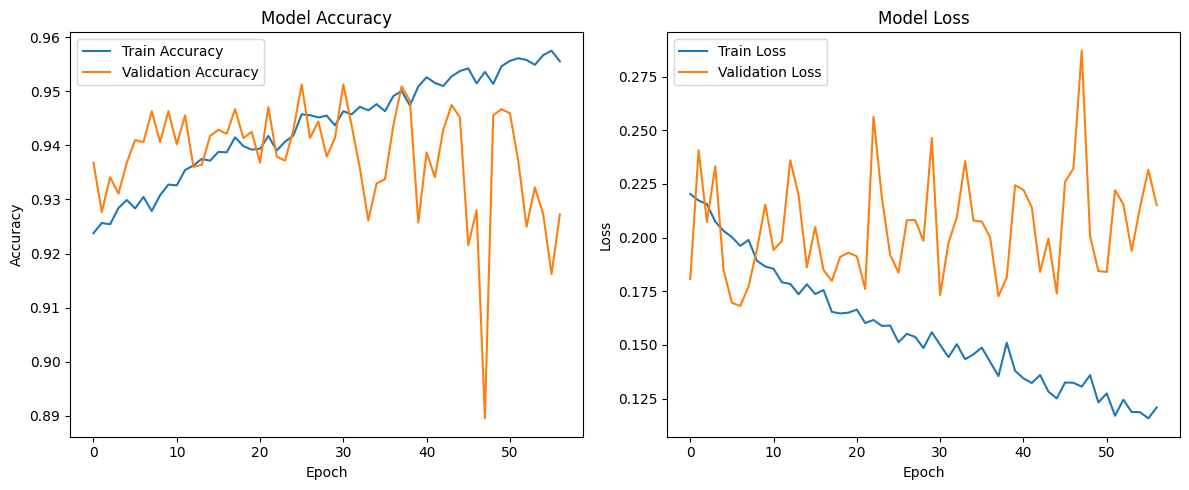

Miglior accuracy: 0.9513 (epoch 26)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.80      0.18      0.30        22
           C       0.89      0.99      0.93      1177
           M       0.98      0.88      0.93        58
        None       0.99      0.99      0.99      1213
           T       0.52      0.14      0.22       156

    accuracy                           0.93      2626
   macro avg       0.84      0.64      0.67      2626
weighted avg       0.91      0.93      0.91      2626



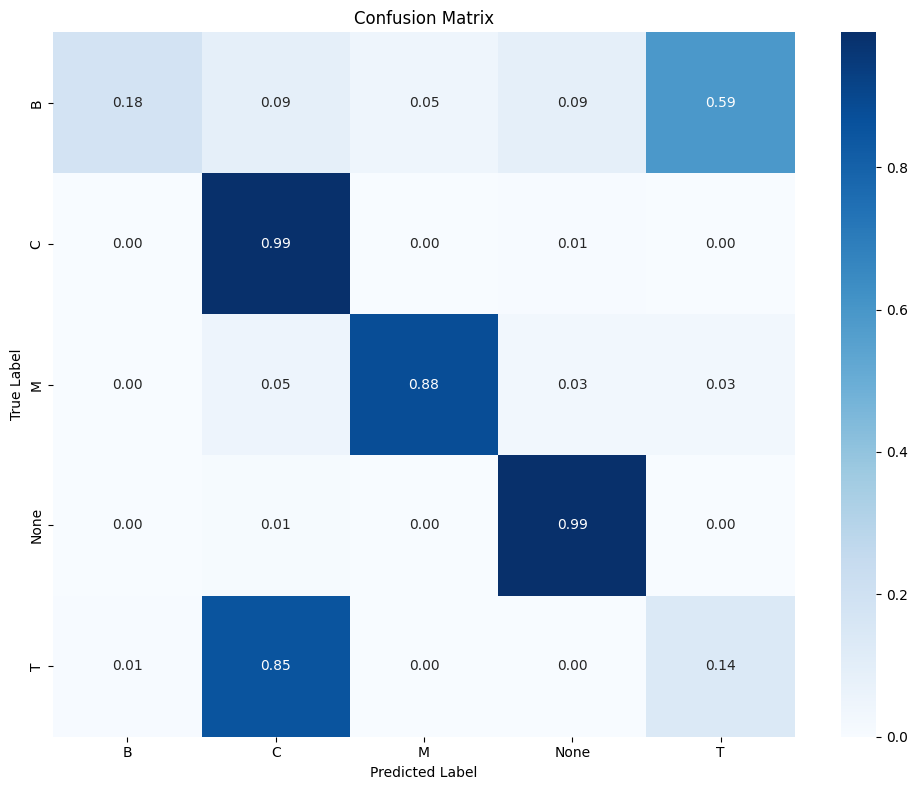

In [ ]:
# STAMPA RISULTATI
plot_and_evaluate_single_output_model(history_1, y_true_1, y_pred_1, class_names=le_vehicle.classes_)

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 2
# ------------------------------------------------------------------------------

'''
Come modello 1, ma più piccolo

Anche se diminuiscono il numero di parametri:
- Rimpicciolire i dense non migliora tanto il tempo di training
- SeparableConv2D non migliora il tempo di training
- GlobalAvgPool2D non migliora il tempo di training

Togliere un layer conv da 64 migliora il tempo di training --> collo di bottiglia sono i conv2D

20 secondi a epoch


Accuracy di 3 punti più bassa rispetto al modello 1
Bus e Truck non li becca manco per sbaglio
'''

model_2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.GlobalAvgPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_2.summary()



model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 186, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 63, 93, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 63, 93, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 61, 91, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 30, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,621 (68.83 KB)

 Trainable params: 17,621 (68.83 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train the model
history_2 = model_2.fit(X_train, y_train_vehicle,
                         validation_data=(X_val, y_val_vehicle),
                         epochs=150,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         verbose=1)

Epoch 1/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5914 - loss: 0.9879

383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.5921 - loss: 0.9866 - val_accuracy: 0.8545 - val_loss: 0.4933
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8405 - loss: 0.5151 - val_accuracy: 0.8564 - val_loss: 0.4978
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8540 - loss: 0.4872

383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8540 - loss: 0.4872 - val_accuracy: 0.8549 - val_loss: 0.4855
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8460 - loss: 0.4906

383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8460 - loss: 0.4906 - val_accuracy: 0.8580 - val_loss: 0.4789
Epoch 5/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8495 - loss: 0.4877 - val_accuracy: 0.8557 - val_loss: 0.5159
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8471 - loss: 0.4934 - val_accuracy: 0.8580 - val_loss: 0.5111
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8529 - loss: 0.4769

383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8529 - loss: 0.4769 - val_accuracy: 0.8591 - val_loss: 0.4661
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8542 - loss: 0.4625 - val_accuracy: 0.8614 - val_loss: 0.4959
Epoch 9/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8532 - loss: 0.4679

383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8532 - loss: 0.4679 - val_accuracy: 0.8610 - val_loss: 0.4626
Epoch 10/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8536 - loss: 0.4542

383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8536 - loss: 0.4542 - val_accuracy: 0.8610 - val_loss: 0.4569
Epoch 11/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8509 - loss: 0.4552 - val_accuracy: 0.8648 - val_loss: 0.4727
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8539 - loss: 0.4603 - val_accuracy: 0.8686 - val_loss: 0.4600
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8526 - loss: 0.4470

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.8526 - loss: 0.4470 - val_accuracy: 0.8660 - val_loss: 0.4380
Epoch 14/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8558 - loss: 0.4393

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8558 - loss: 0.4394 - val_accuracy: 0.8701 - val_loss: 0.4193
Epoch 15/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8592 - loss: 0.4262 - val_accuracy: 0.8462 - val_loss: 0.5154
Epoch 16/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8588 - loss: 0.4253

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8588 - loss: 0.4253 - val_accuracy: 0.8781 - val_loss: 0.3940
Epoch 17/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8692 - loss: 0.3966

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8692 - loss: 0.3966 - val_accuracy: 0.8800 - val_loss: 0.3672
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8659 - loss: 0.4024 - val_accuracy: 0.8800 - val_loss: 0.3875
Epoch 19/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8754 - loss: 0.3801 - val_accuracy: 0.8827 - val_loss: 0.4012
Epoch 20/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8708 - loss: 0.3999 - val_accuracy: 0.8827 - val_loss: 0.3795
Epoch 21/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8757 - loss: 0.3780

383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8757 - loss: 0.3781 - val_accuracy: 0.8827 - val_loss: 0.3628
Epoch 22/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8677 - loss: 0.3909 - val_accuracy: 0.8724 - val_loss: 0.4155
Epoch 23/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8745 - loss: 0.3812

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8745 - loss: 0.3813 - val_accuracy: 0.8816 - val_loss: 0.3589
Epoch 24/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8704 - loss: 0.3885 - val_accuracy: 0.8781 - val_loss: 0.4229
Epoch 25/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8720 - loss: 0.3893 - val_accuracy: 0.8831 - val_loss: 0.3616
Epoch 26/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8738 - loss: 0.3836 - val_accuracy: 0.8637 - val_loss: 0.4515
Epoch 27/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8760 - loss: 0.3833 - val_accuracy: 0.8922 - val_loss: 0.3614
Epoch 28/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8782 - loss: 0.3736

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8782 - loss: 0.3736 - val_accuracy: 0.8899 - val_loss: 0.3309
Epoch 29/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8764 - loss: 0.3762 - val_accuracy: 0.8736 - val_loss: 0.4027
Epoch 30/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8794 - loss: 0.3597 - val_accuracy: 0.8778 - val_loss: 0.3957
Epoch 31/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8852 - loss: 0.3510 - val_accuracy: 0.8264 - val_loss: 0.4704
Epoch 32/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8917 - loss: 0.3406 - val_accuracy: 0.8941 - val_loss: 0.3354
Epoch 33/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8883 - loss: 0.3489

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8883 - loss: 0.3489 - val_accuracy: 0.8983 - val_loss: 0.3155
Epoch 34/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8955 - loss: 0.3307 - val_accuracy: 0.8686 - val_loss: 0.4215
Epoch 35/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8928 - loss: 0.3328

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8928 - loss: 0.3328 - val_accuracy: 0.8991 - val_loss: 0.3052
Epoch 36/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8936 - loss: 0.3280 - val_accuracy: 0.9006 - val_loss: 0.3087
Epoch 37/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8887 - loss: 0.3350 - val_accuracy: 0.8934 - val_loss: 0.3287
Epoch 38/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8978 - loss: 0.3201 - val_accuracy: 0.8934 - val_loss: 0.3461
Epoch 39/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8953 - loss: 0.3244 - val_accuracy: 0.8865 - val_loss: 0.3480
Epoch 40/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8955 - loss: 0.3293 - val_accuracy: 0.8987 - val_loss: 0.3217
Epoch 41/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8967 - loss: 0.3181 - val_accuracy: 0.8979 - val_loss: 0.3284
Epoch 42/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8965 - loss: 0.3135

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8994 - loss: 0.3072 - val_accuracy: 0.9040 - val_loss: 0.3039
Epoch 44/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9027 - loss: 0.3011 - val_accuracy: 0.8991 - val_loss: 0.3123
Epoch 45/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8989 - loss: 0.3096 - val_accuracy: 0.8964 - val_loss: 0.3303
Epoch 46/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9043 - loss: 0.2924

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9043 - loss: 0.2924 - val_accuracy: 0.9071 - val_loss: 0.3037
Epoch 47/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9031 - loss: 0.3002

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9031 - loss: 0.3002 - val_accuracy: 0.9105 - val_loss: 0.2785
Epoch 48/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9032 - loss: 0.2976 - val_accuracy: 0.8915 - val_loss: 0.3270
Epoch 49/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9043 - loss: 0.2910 - val_accuracy: 0.8709 - val_loss: 0.3844
Epoch 50/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9024 - loss: 0.3003 - val_accuracy: 0.8998 - val_loss: 0.2970
Epoch 51/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9039 - loss: 0.2992

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9039 - loss: 0.2992 - val_accuracy: 0.9177 - val_loss: 0.2662
Epoch 52/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9039 - loss: 0.2949 - val_accuracy: 0.9025 - val_loss: 0.3093
Epoch 53/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9074 - loss: 0.2805 - val_accuracy: 0.8964 - val_loss: 0.3433
Epoch 54/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9063 - loss: 0.2920 - val_accuracy: 0.9082 - val_loss: 0.2841
Epoch 55/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9037 - loss: 0.2956 - val_accuracy: 0.9128 - val_loss: 0.2685
Epoch 56/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9049 - loss: 0.2843 - val_accuracy: 0.9097 - val_loss: 0.2863
Epoch 57/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9067 - loss: 0.2805 - val_accuracy: 0.9136 - val_loss: 0.2744
Epoch 58/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9136 - loss: 0.2726

383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9112 - loss: 0.2744 - val_accuracy: 0.9139 - val_loss: 0.2654
Epoch 67/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9104 - loss: 0.2731 - val_accuracy: 0.9101 - val_loss: 0.2948
Epoch 68/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9164 - loss: 0.2652 - val_accuracy: 0.9097 - val_loss: 0.2932
Epoch 69/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9120 - loss: 0.2672 - val_accuracy: 0.9082 - val_loss: 0.2994
Epoch 70/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9083 - loss: 0.2847 - val_accuracy: 0.9048 - val_loss: 0.3011
Epoch 71/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9079 - loss: 0.2797

383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9079 - loss: 0.2797 - val_accuracy: 0.9185 - val_loss: 0.2517
Epoch 72/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9110 - loss: 0.2688 - val_accuracy: 0.9132 - val_loss: 0.2905
Epoch 73/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9143 - loss: 0.2626 - val_accuracy: 0.9044 - val_loss: 0.2900
Epoch 74/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9108 - loss: 0.2668 - val_accuracy: 0.9136 - val_loss: 0.2631
Epoch 75/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9083 - loss: 0.2764 - val_accuracy: 0.9193 - val_loss: 0.2605
Epoch 76/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9133 - loss: 0.2653 - val_accuracy: 0.9052 - val_loss: 0.2919
Epoch 77/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9088 - loss: 0.2726 - val_accuracy: 0.9231 - val_loss: 0.2636
Epoch 78/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9148 - loss: 0.2593

383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9168 - loss: 0.2537 - val_accuracy: 0.9193 - val_loss: 0.2513
Epoch 92/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9134 - loss: 0.2578 - val_accuracy: 0.9204 - val_loss: 0.2616
Epoch 93/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9125 - loss: 0.2634 - val_accuracy: 0.9158 - val_loss: 0.2741
Epoch 94/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9161 - loss: 0.2551 - val_accuracy: 0.9101 - val_loss: 0.2818
Epoch 95/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9152 - loss: 0.2538

383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9152 - loss: 0.2538 - val_accuracy: 0.9242 - val_loss: 0.2384
Epoch 96/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9157 - loss: 0.2547 - val_accuracy: 0.9082 - val_loss: 0.2769
Epoch 97/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9186 - loss: 0.2521 - val_accuracy: 0.9155 - val_loss: 0.2616
Epoch 98/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9149 - loss: 0.2562 - val_accuracy: 0.9189 - val_loss: 0.2653
Epoch 99/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9167 - loss: 0.2555 - val_accuracy: 0.9158 - val_loss: 0.2840
Epoch 100/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9144 - loss: 0.2559 - val_accuracy: 0.9136 - val_loss: 0.2695
Epoch 101/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9160 - loss: 0.2528 - val_accuracy: 0.9177 - val_loss: 0.2637
Epoch 102/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9150 - loss: 0.2

In [48]:
# TEST
best_model_2 = tf.keras.models.load_model('best_model_2.h5')

test_loss_2, test_acc_2 = model_2.evaluate(X_test, y_test_vehicle, verbose=1)
print(f"\nTest accuracy: {test_acc_2:.4f}")
print(f"Test loss: {test_loss_2:.4f}")

y_pred_prob_2 = model_2.predict(X_test)
y_pred_2 = np.argmax(y_pred_prob_2, axis=1)
y_true_2 = np.argmax(y_test_vehicle, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9178 - loss: 0.2551

Test accuracy: 0.9120
Test loss: 0.2689
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


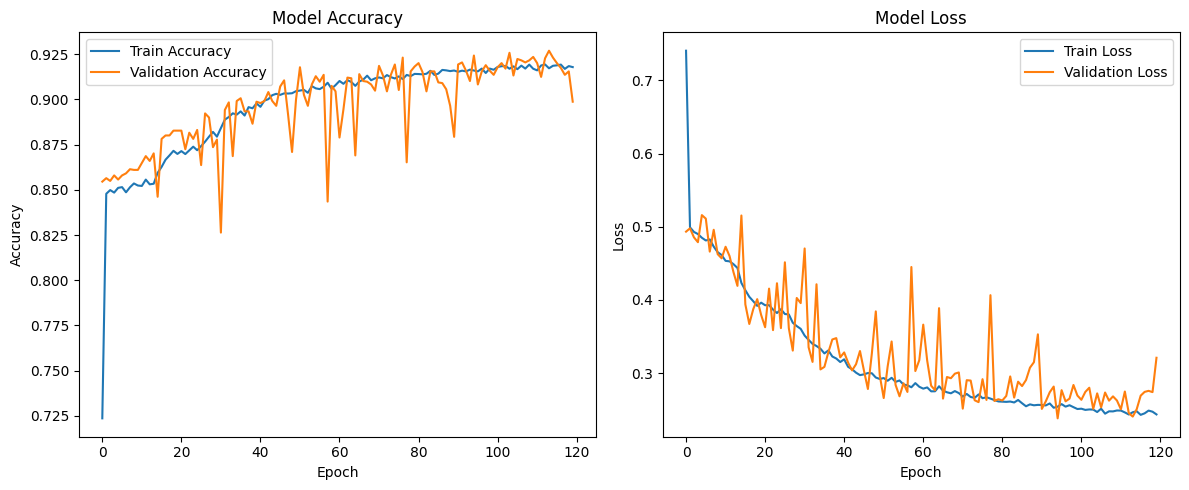

Miglior accuracy: 0.9269 (epoch 114)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.00      0.00      0.00        22
           C       0.85      0.99      0.91      1177
           M       0.90      0.91      0.91        58
        None       0.99      0.97      0.98      1213
           T       0.00      0.00      0.00       156

    accuracy                           0.91      2626
   macro avg       0.55      0.57      0.56      2626
weighted avg       0.86      0.91      0.88      2626



c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

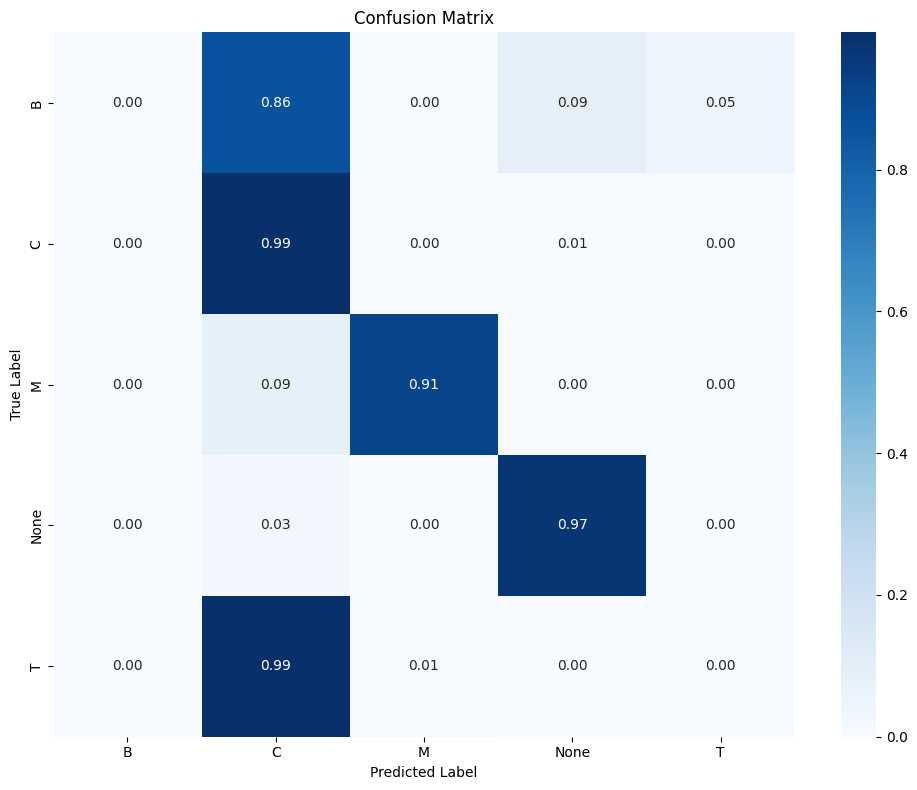

In [49]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_2, y_true_2, y_pred_2, class_names=le_vehicle.classes_)

Original class distribution: {'B': np.int64(106), 'C': np.int64(7804), 'M': np.int64(430), 'None': np.int64(8144), 'T': np.int64(1022)}
Target count per class: 106
Balanced class distribution: {'B': np.int64(106), 'C': np.int64(106), 'M': np.int64(106), 'None': np.int64(106), 'T': np.int64(106)}

Number of audio files per vehicle class (Original Full Dataset):
vehicle
None    8144
C       7804
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Full Dataset):
C       106
T       106
B       106
None    106
M       106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Training Set):
B       78
C       68
M       75
None    72
T       78
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Validation Set):
B       13
C       21
M       13
None    14
T       18
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Test Set):
B       15
C       17
M     

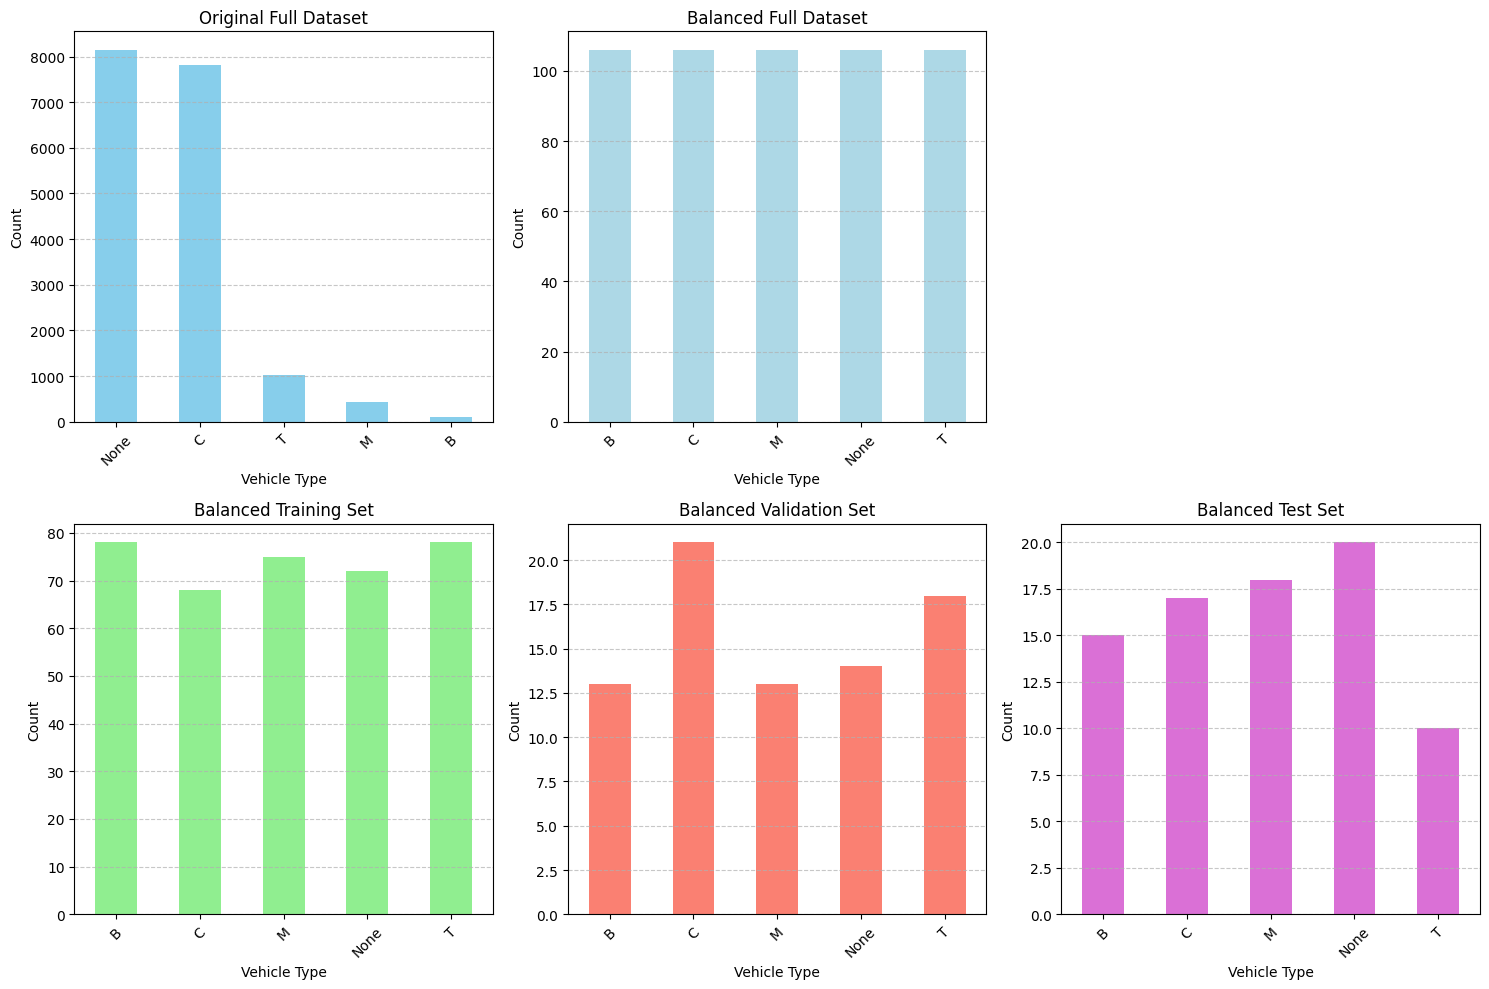

<Figure size 1200x600 with 0 Axes>

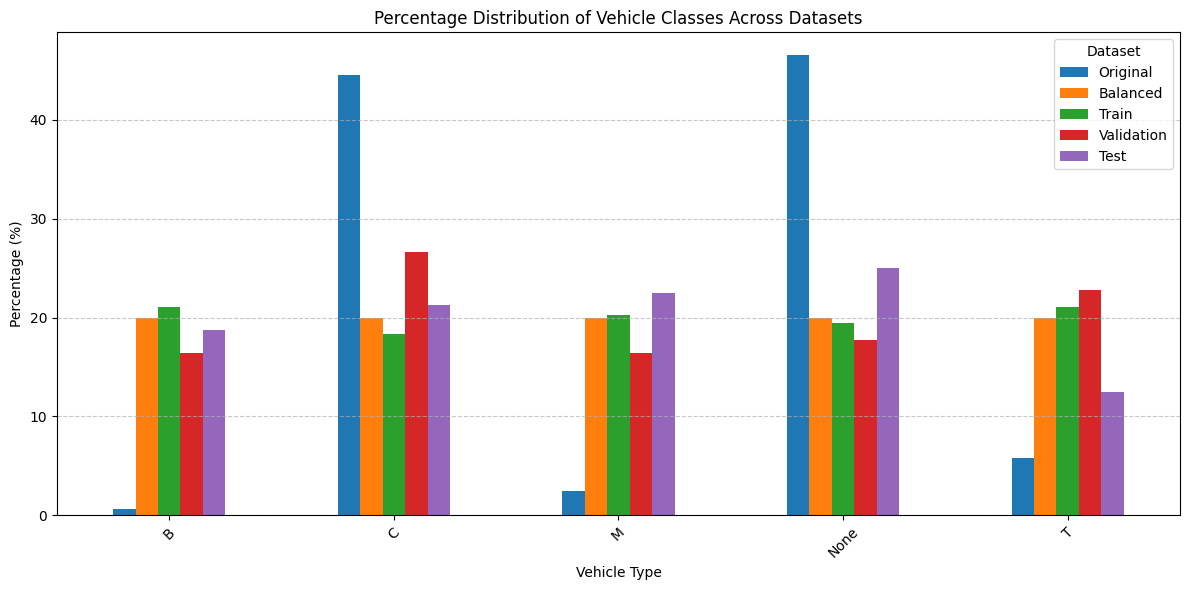

In [61]:
# Balanced dataset creation
def create_balanced_dataset(spectrograms, vehicle_labels, direction_labels, target_count=None, random_state=42):
    '''
    Parameters:
        target_count: numero a cui croppare le categorie in eccesso
    '''
    # Convert one-hot encoded labels back to indices
    vehicle_indices = np.argmax(vehicle_labels, axis=1)
    
    # Count samples per class
    unique_classes, class_counts = np.unique(vehicle_indices, return_counts=True)
    class_distribution = dict(zip(unique_classes, class_counts))
    print("Original class distribution:", 
          {le_vehicle.classes_[cls]: count for cls, count in class_distribution.items()})
    
    # Determine target count (you can adjust this as needed)
    # Using the minimum class count as target ensures all classes have equal representation
    if target_count == None:
        target_count = min(class_counts)
    print(f"Target count per class: {target_count}")
    
    # Create balanced dataset
    balanced_indices = []
    np.random.seed(random_state)
    
    for class_idx in unique_classes:
        # Get indices of samples from this class
        class_sample_indices = np.where(vehicle_indices == class_idx)[0]
        
        # If class is overrepresented, randomly select target_count samples
        if len(class_sample_indices) > target_count:
            selected_indices = np.random.choice(class_sample_indices, target_count, replace=False)
        else:
            selected_indices = class_sample_indices
            
        balanced_indices.extend(selected_indices)
    
    # Shuffle the balanced dataset
    np.random.shuffle(balanced_indices)
    
    # Create the balanced dataset
    balanced_spectrograms = spectrograms[balanced_indices]
    balanced_vehicle_labels = vehicle_labels[balanced_indices]
    balanced_direction_labels = direction_labels[balanced_indices]
    
    # Verify balanced distribution
    new_counts = np.unique(np.argmax(balanced_vehicle_labels, axis=1), return_counts=True)
    print("Balanced class distribution:", 
          {le_vehicle.classes_[cls]: count for cls, count in zip(new_counts[0], new_counts[1])})
    
    return balanced_spectrograms, balanced_vehicle_labels, balanced_direction_labels

# Create balanced dataset
perf_balanced_spectrograms, perf_balanced_vehicle_labels, perf_balanced_direction_labels = create_balanced_dataset(
    spectograms_reshaped, labels_cat_vehicles, labels_cat_direction
)

# Split the balanced dataset
# 1. First split: Train (70%) and Temporary (30%)
X_train_perf_bal, X_temp_perf_bal, y_train_vehicle_perf_bal, y_temp_vehicle_perf_bal, y_train_direction_perf_bal, y_temp_direction_perf_bal = train_test_split(
    perf_balanced_spectrograms, 
    perf_balanced_vehicle_labels, 
    perf_balanced_direction_labels,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# 2. Second split: Temporary into Validation (15%) and Test (15%)
X_val_perf_bal, X_test_perf_bal, y_val_vehicle_perf_bal, y_test_vehicle_perf_bal, y_val_direction_perf_bal, y_test_direction_perf_bal = train_test_split(
    X_temp_perf_bal, 
    y_temp_vehicle_perf_bal, 
    y_temp_direction_perf_bal,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

# STAMPE

# 1. Count in the full dataset (original, unbalanced)
vehicle_counts_full = df_dataset["vehicle"].value_counts()
print("\nNumber of audio files per vehicle class (Original Full Dataset):")
print(vehicle_counts_full)

# Get the class distribution in the balanced dataset
balanced_vehicle_indices = np.argmax(balanced_vehicle_labels, axis=1)
balanced_counts_full = pd.Series(balanced_vehicle_indices).map(lambda idx: le_vehicle.classes_[idx]).value_counts()
print("\nNumber of audio files per vehicle class (Balanced Full Dataset):")
print(balanced_counts_full)

# 2. Count in the balanced split datasets
# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(y_train_vehicle_perf_bal, axis=1)
y_val_indices = np.argmax(y_val_vehicle_perf_bal, axis=1)
y_test_indices = np.argmax(y_test_vehicle_perf_bal, axis=1)

# Get the class names in the correct order
class_names = le_vehicle.classes_

# Create DataFrames for counting
train_counts = pd.Series(y_train_indices).map(lambda idx: class_names[idx]).value_counts()
val_counts = pd.Series(y_val_indices).map(lambda idx: class_names[idx]).value_counts()
test_counts = pd.Series(y_test_indices).map(lambda idx: class_names[idx]).value_counts()

# Ensure all classes are present in each count (even if zero)
for counts in [train_counts, val_counts, test_counts, balanced_counts_full]:
    for class_name in class_names:
        if class_name not in counts:
            counts[class_name] = 0
    counts.sort_index(inplace=True)

# Print counts for each split
print("\nNumber of audio files per vehicle class (Balanced Training Set):")
print(train_counts)
print("\nNumber of audio files per vehicle class (Balanced Validation Set):")
print(val_counts)
print("\nNumber of audio files per vehicle class (Balanced Test Set):")
print(test_counts)

# Visualize the class distribution
plt.figure(figsize=(15, 10))

# Original full dataset
plt.subplot(2, 3, 1)
vehicle_counts_full.plot(kind='bar', color='skyblue')
plt.title('Original Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced full dataset
plt.subplot(2, 3, 2)
balanced_counts_full.plot(kind='bar', color='lightblue')
plt.title('Balanced Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced training set
plt.subplot(2, 3, 4)
train_counts.plot(kind='bar', color='lightgreen')
plt.title('Balanced Training Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced validation set
plt.subplot(2, 3, 5)
val_counts.plot(kind='bar', color='salmon')
plt.title('Balanced Validation Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced test set
plt.subplot(2, 3, 6)
test_counts.plot(kind='bar', color='orchid')
plt.title('Balanced Test Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a percentage distribution chart for comparison
plt.figure(figsize=(12, 6))

# Create a DataFrame with all counts for easy comparison
counts_df = pd.DataFrame({
    'Original': vehicle_counts_full / vehicle_counts_full.sum() * 100,
    'Balanced': balanced_counts_full / balanced_counts_full.sum() * 100,
    'Train': train_counts / train_counts.sum() * 100,
    'Validation': val_counts / val_counts.sum() * 100,
    'Test': test_counts / test_counts.sum() * 100
})

# Plot percentage distribution
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage Distribution of Vehicle Classes Across Datasets')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 3
# ------------------------------------------------------------------------------

'''
Come modello 2, ma con dataset perfettamente bilanciato

dataset molto piccolo, quindi ci mette pochissimo a trainare

accuracy bassissima, praticamente becca i None e il resto pensa sia tutto Truck
'''

model_3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.GlobalAvgPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_3.summary()



model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_3.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 186, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 93, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 63, 93, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 91, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 30, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,621 (68.83 KB)

 Trainable params: 17,621 (68.83 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train the model
history_3 = model_3.fit(X_train_perf_bal, y_train_vehicle_perf_bal,
                         validation_data=(X_val_perf_bal, y_val_vehicle_perf_bal),
                         epochs=150,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         verbose=1)

Epoch 1/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1871 - loss: 1.6099

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.1878 - loss: 1.6100 - val_accuracy: 0.1646 - val_loss: 1.6092
Epoch 2/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2288 - loss: 1.6046

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2259 - loss: 1.6049 - val_accuracy: 0.1646 - val_loss: 1.6080
Epoch 3/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2366 - loss: 1.6061

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2350 - loss: 1.6059 - val_accuracy: 0.2278 - val_loss: 1.6051
Epoch 4/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1963 - loss: 1.6042

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1980 - loss: 1.6039 - val_accuracy: 0.2658 - val_loss: 1.6005
Epoch 5/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2476 - loss: 1.5983

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2419 - loss: 1.5984 - val_accuracy: 0.2278 - val_loss: 1.5942
Epoch 6/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2317 - loss: 1.5833

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2309 - loss: 1.5845 - val_accuracy: 0.2785 - val_loss: 1.5926
Epoch 7/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2968 - loss: 1.5875

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2901 - loss: 1.5864 - val_accuracy: 0.2658 - val_loss: 1.5605
Epoch 8/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2675 - loss: 1.5606

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2728 - loss: 1.5592 - val_accuracy: 0.3038 - val_loss: 1.5102
Epoch 9/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2607 - loss: 1.5172

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2649 - loss: 1.5177 - val_accuracy: 0.3165 - val_loss: 1.4583
Epoch 10/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3162 - loss: 1.5038

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3149 - loss: 1.5038 - val_accuracy: 0.4430 - val_loss: 1.4121
Epoch 11/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3097 - loss: 1.4628

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3098 - loss: 1.4618 - val_accuracy: 0.4557 - val_loss: 1.3781
Epoch 12/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3265 - loss: 1.4221

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3272 - loss: 1.4186 - val_accuracy: 0.4430 - val_loss: 1.3349
Epoch 13/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3480 - loss: 1.3887

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3475 - loss: 1.3886 - val_accuracy: 0.4051 - val_loss: 1.2832
Epoch 14/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3914 - loss: 1.3551 - val_accuracy: 0.4304 - val_loss: 1.3083
Epoch 15/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3528 - loss: 1.3326 - val_accuracy: 0.3924 - val_loss: 1.3775
Epoch 16/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4193 - loss: 1.3008 - val_accuracy: 0.4304 - val_loss: 1.2938
Epoch 17/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3729 - loss: 1.2826 - val_accuracy: 0.4430 - val_loss: 1.3031
Epoch 18/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3406 - loss: 1.2992 - val_accuracy: 0.3924 - val_loss: 1.3040
Epoch 19/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4057 - loss: 1.2476

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4042 - loss: 1.2495 - val_accuracy: 0.4937 - val_loss: 1.2106
Epoch 20/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3968 - loss: 1.2696 - val_accuracy: 0.4304 - val_loss: 1.3201
Epoch 21/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4406 - loss: 1.1828 - val_accuracy: 0.4810 - val_loss: 1.2137
Epoch 22/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3885 - loss: 1.2639 - val_accuracy: 0.2911 - val_loss: 1.4205
Epoch 23/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3863 - loss: 1.2469 - val_accuracy: 0.4810 - val_loss: 1.2445
Epoch 24/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3528 - loss: 1.2455

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3595 - loss: 1.2451 - val_accuracy: 0.4937 - val_loss: 1.1980
Epoch 25/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3777 - loss: 1.2261 - val_accuracy: 0.3544 - val_loss: 1.2761
Epoch 26/150
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4080 - loss: 1.1796

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4062 - loss: 1.1873 - val_accuracy: 0.4810 - val_loss: 1.1980
Epoch 27/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4163 - loss: 1.2120 - val_accuracy: 0.3671 - val_loss: 1.2556
Epoch 28/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4446 - loss: 1.1834 - val_accuracy: 0.5190 - val_loss: 1.2182
Epoch 29/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3679 - loss: 1.2750 - val_accuracy: 0.3418 - val_loss: 1.2295
Epoch 30/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4239 - loss: 1.2020 - val_accuracy: 0.4430 - val_loss: 1.2150
Epoch 31/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4277 - loss: 1.1982 - val_accuracy: 0.4684 - val_loss: 1.1985
Epoch 32/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3918 - loss: 1.2586 - val_accuracy: 0.3291 - val_loss: 1.2190
Epoch 33/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4070 - loss: 1.2554 - val_accuracy: 0.4557 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4022 - loss: 1.2285 - val_accuracy: 0.4430 - val_loss: 1.1973
Epoch 41/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4128 - loss: 1.1975 - val_accuracy: 0.3165 - val_loss: 1.2696
Epoch 42/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3855 - loss: 1.2642 - val_accuracy: 0.3291 - val_loss: 1.2931
Epoch 43/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4206 - loss: 1.2266 - val_accuracy: 0.4304 - val_loss: 1.2113
Epoch 44/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4268 - loss: 1.2295 - val_accuracy: 0.4810 - val_loss: 1.2022
Epoch 45/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4341 - loss: 1.1629 - val_accuracy: 0.3291 - val_loss: 1.2761
Epoch 46/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4391 - loss: 1.2064 - val_accuracy: 0.4304 - val_loss: 1.2195
Epoch 47/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4307 - loss: 1.1934 - val_accuracy: 0.3418 

In [58]:
# TEST
best_model_3 = tf.keras.models.load_model('best_model_3.h5')

test_loss_3, test_acc_3 = model_3.evaluate(X_test_perf_bal, y_test_vehicle_perf_bal, verbose=1)
print(f"\nTest accuracy: {test_acc_3:.4f}")
print(f"Test loss: {test_loss_3:.4f}")

y_pred_prob_3 = model_3.predict(X_test_perf_bal)
y_pred_3 = np.argmax(y_pred_prob_3, axis=1)
y_true_3 = np.argmax(y_test_vehicle_perf_bal, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3938 - loss: 1.1230

Test accuracy: 0.4125
Test loss: 1.1002
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


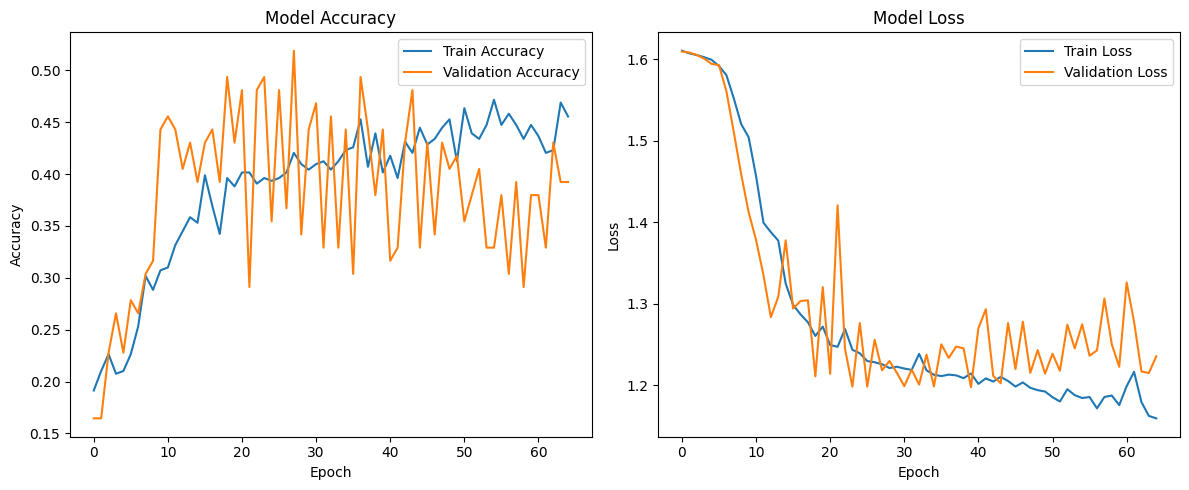

Miglior accuracy: 0.5190 (epoch 28)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.55      0.40      0.46        15
           C       0.00      0.00      0.00        17
           M       0.00      0.00      0.00        18
        None       1.00      0.90      0.95        20
           T       0.18      0.90      0.30        10

    accuracy                           0.41        80
   macro avg       0.34      0.44      0.34        80
weighted avg       0.37      0.41      0.36        80



c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

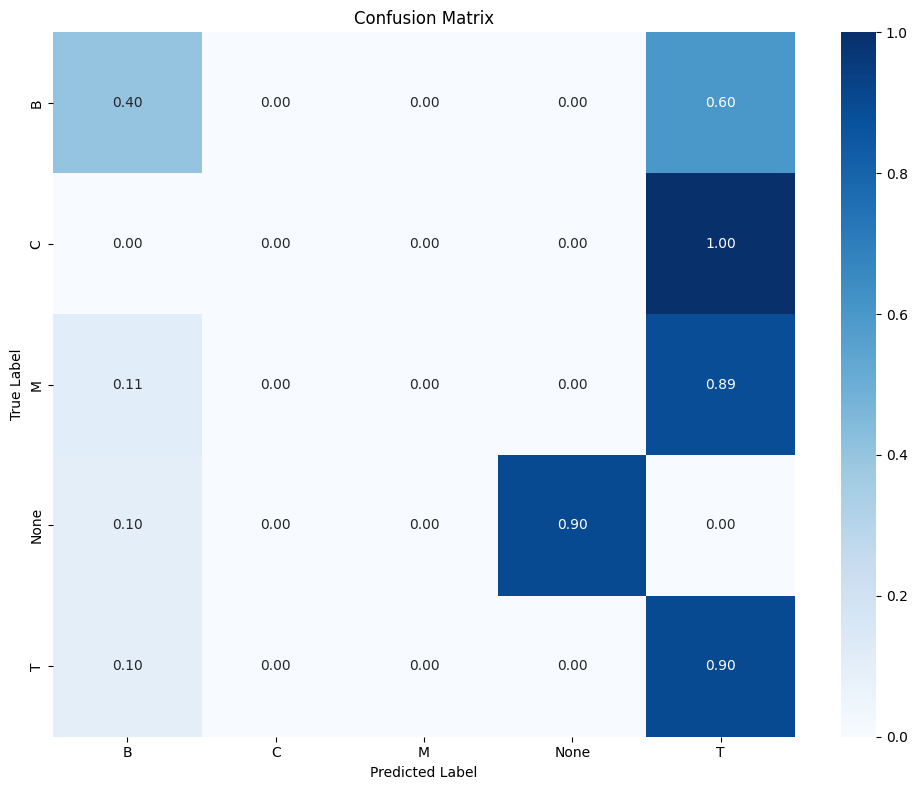

In [59]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_3, y_true_3, y_pred_3, class_names=le_vehicle.classes_)

Original class distribution: {'B': np.int64(106), 'C': np.int64(7804), 'M': np.int64(430), 'None': np.int64(8144), 'T': np.int64(1022)}
Target count per class: 1000
Balanced class distribution: {'B': np.int64(106), 'C': np.int64(1000), 'M': np.int64(430), 'None': np.int64(1000), 'T': np.int64(1000)}

Number of audio files per vehicle class (Original Full Dataset):
vehicle
None    8144
C       7804
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Full Dataset):
None    1000
T       1000
C       1000
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Training Set):
B        73
C       714
M       295
None    680
T       713
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Validation Set):
B        21
C       145
M        66
None    164
T       134
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Test Set):
B        

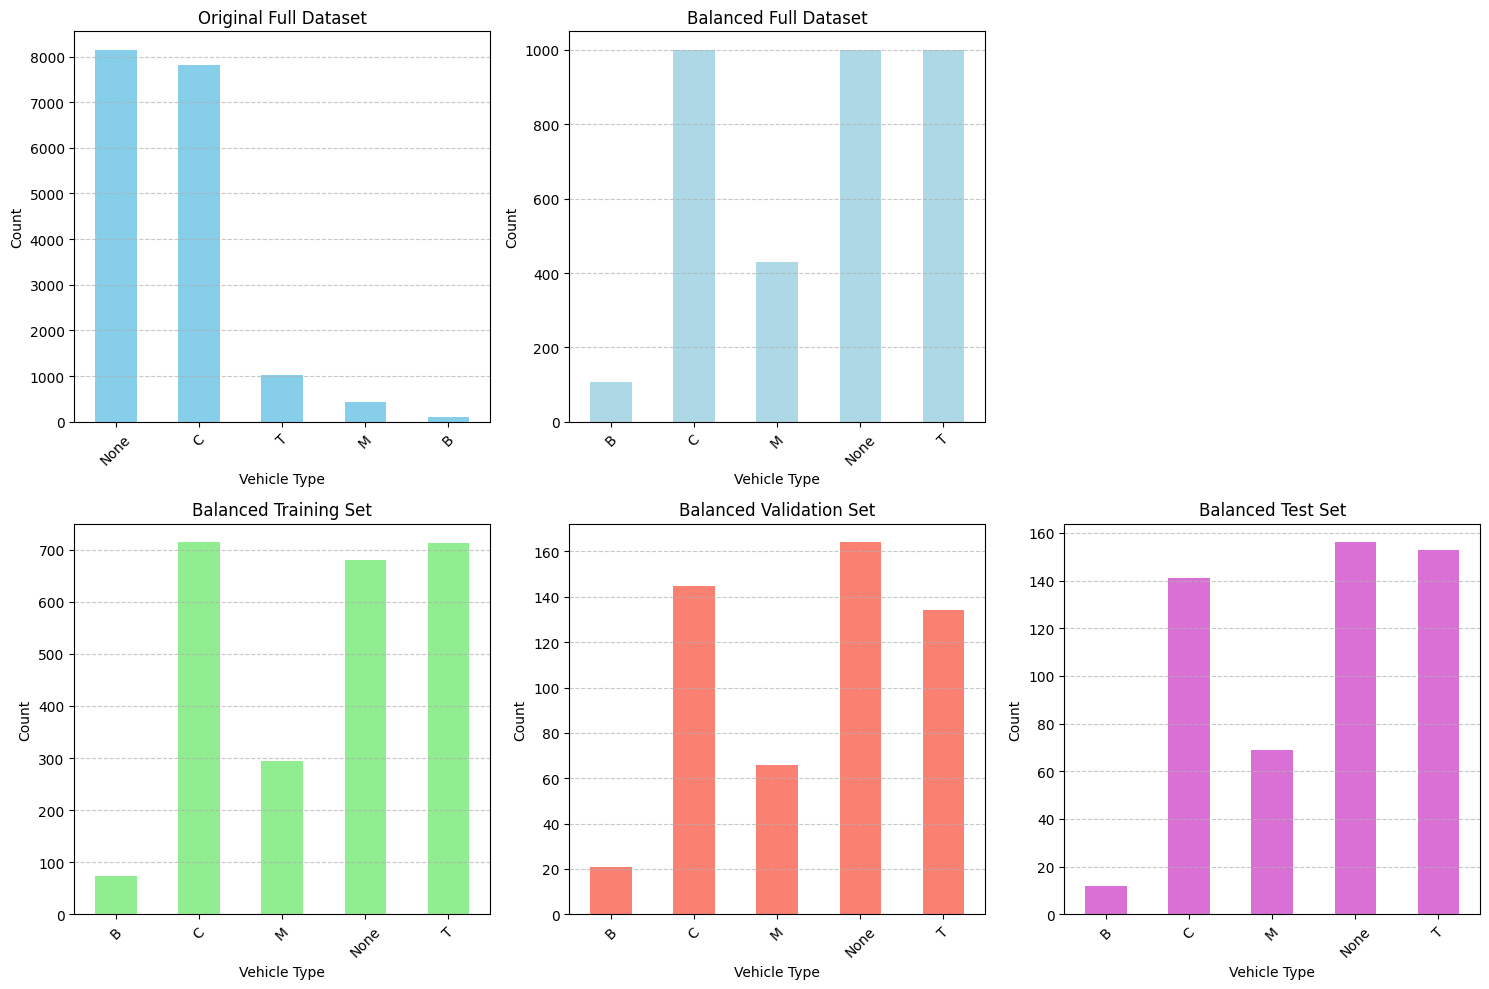

<Figure size 1200x600 with 0 Axes>

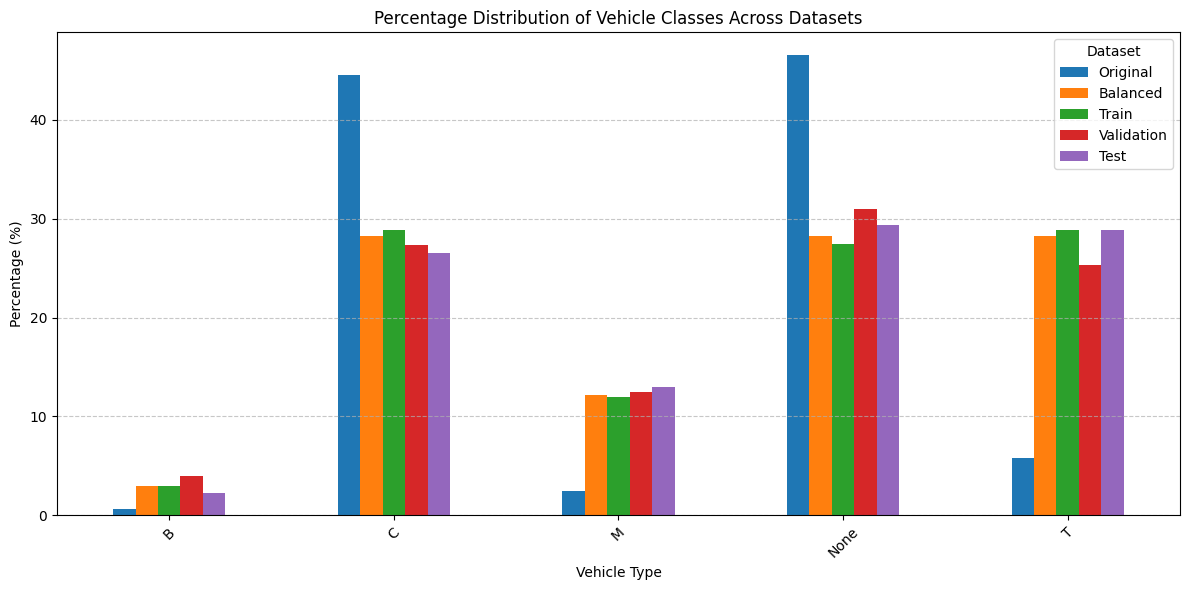

In [62]:
# Create balanced dataset
balanced_spectrograms_1000, balanced_vehicle_labels_1000, balanced_direction_labels_1000 = create_balanced_dataset(
    spectograms_reshaped, labels_cat_vehicles, labels_cat_direction,
    target_count = 1000
)

# Split the balanced dataset
# 1. First split: Train (70%) and Temporary (30%)
X_train_bal_1000, X_temp_bal_1000, y_train_vehicle_bal_1000, y_temp_vehicle_bal_1000, y_train_direction_bal_1000, y_temp_direction_bal_1000 = train_test_split(
    balanced_spectrograms_1000, 
    balanced_vehicle_labels_1000, 
    balanced_direction_labels_1000,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# 2. Second split: Temporary into Validation (15%) and Test (15%)
X_val_bal_1000, X_test_bal_1000, y_val_vehicle_bal_1000, y_test_vehicle_bal_1000, y_val_direction_bal_1000, y_test_direction_bal_1000 = train_test_split(
    X_temp_bal_1000,
    y_temp_vehicle_bal_1000, 
    y_temp_direction_bal_1000,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

# STAMPE

# 1. Count in the full dataset (original, unbalanced)
vehicle_counts_full = df_dataset["vehicle"].value_counts()
print("\nNumber of audio files per vehicle class (Original Full Dataset):")
print(vehicle_counts_full)

# Get the class distribution in the balanced dataset
balanced_vehicle_indices = np.argmax(balanced_vehicle_labels_1000, axis=1)
balanced_counts_full = pd.Series(balanced_vehicle_indices).map(lambda idx: le_vehicle.classes_[idx]).value_counts()
print("\nNumber of audio files per vehicle class (Balanced Full Dataset):")
print(balanced_counts_full)

# 2. Count in the balanced split datasets
# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(y_train_vehicle_bal_1000, axis=1)
y_val_indices = np.argmax(y_val_vehicle_bal_1000, axis=1)
y_test_indices = np.argmax(y_test_vehicle_bal_1000, axis=1)

# Get the class names in the correct order
class_names = le_vehicle.classes_

# Create DataFrames for counting
train_counts = pd.Series(y_train_indices).map(lambda idx: class_names[idx]).value_counts()
val_counts = pd.Series(y_val_indices).map(lambda idx: class_names[idx]).value_counts()
test_counts = pd.Series(y_test_indices).map(lambda idx: class_names[idx]).value_counts()

# Ensure all classes are present in each count (even if zero)
for counts in [train_counts, val_counts, test_counts, balanced_counts_full]:
    for class_name in class_names:
        if class_name not in counts:
            counts[class_name] = 0
    counts.sort_index(inplace=True)

# Print counts for each split
print("\nNumber of audio files per vehicle class (Balanced Training Set):")
print(train_counts)
print("\nNumber of audio files per vehicle class (Balanced Validation Set):")
print(val_counts)
print("\nNumber of audio files per vehicle class (Balanced Test Set):")
print(test_counts)

# Visualize the class distribution
plt.figure(figsize=(15, 10))

# Original full dataset
plt.subplot(2, 3, 1)
vehicle_counts_full.plot(kind='bar', color='skyblue')
plt.title('Original Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced full dataset
plt.subplot(2, 3, 2)
balanced_counts_full.plot(kind='bar', color='lightblue')
plt.title('Balanced Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced training set
plt.subplot(2, 3, 4)
train_counts.plot(kind='bar', color='lightgreen')
plt.title('Balanced Training Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced validation set
plt.subplot(2, 3, 5)
val_counts.plot(kind='bar', color='salmon')
plt.title('Balanced Validation Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced test set
plt.subplot(2, 3, 6)
test_counts.plot(kind='bar', color='orchid')
plt.title('Balanced Test Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a percentage distribution chart for comparison
plt.figure(figsize=(12, 6))

# Create a DataFrame with all counts for easy comparison
counts_df = pd.DataFrame({
    'Original': vehicle_counts_full / vehicle_counts_full.sum() * 100,
    'Balanced': balanced_counts_full / balanced_counts_full.sum() * 100,
    'Train': train_counts / train_counts.sum() * 100,
    'Validation': val_counts / val_counts.sum() * 100,
    'Test': test_counts / test_counts.sum() * 100
})

# Plot percentage distribution
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage Distribution of Vehicle Classes Across Datasets')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [63]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 4
# ------------------------------------------------------------------------------

'''
Come modello 2, ma con dataset bilanciato a max 1000 samples per classe
'''

model_4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.GlobalAvgPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_4.summary()



model_4.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_4.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 126, 186, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 63, 93, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 63, 93, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 61, 91, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 30, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,621 (68.83 KB)

 Trainable params: 17,621 (68.83 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Train the model
history_4 = model_4.fit(X_train_bal_1000, y_train_vehicle_bal_1000,
                         validation_data=(X_val_bal_1000, y_val_vehicle_bal_1000),
                         epochs=150,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         verbose=1)

Epoch 1/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2789 - loss: 1.5129

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.2795 - loss: 1.5114 - val_accuracy: 0.5038 - val_loss: 1.4180
Epoch 2/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4391 - loss: 1.3388

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4392 - loss: 1.3371 - val_accuracy: 0.5000 - val_loss: 1.1600
Epoch 3/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4974 - loss: 1.1068

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4974 - loss: 1.1062 - val_accuracy: 0.5453 - val_loss: 1.0278
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5316 - loss: 0.9853

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5316 - loss: 0.9855 - val_accuracy: 0.5472 - val_loss: 0.9589
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5448 - loss: 0.9552 - val_accuracy: 0.5283 - val_loss: 0.9781
Epoch 6/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5391 - loss: 0.9473

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5392 - loss: 0.9471 - val_accuracy: 0.5528 - val_loss: 0.9128
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5330 - loss: 0.9222

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5331 - loss: 0.9223 - val_accuracy: 0.5717 - val_loss: 0.9088
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5573 - loss: 0.8945

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5572 - loss: 0.8948 - val_accuracy: 0.5887 - val_loss: 0.9058
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5592 - loss: 0.9192 - val_accuracy: 0.5830 - val_loss: 0.9432
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5592 - loss: 0.9017 - val_accuracy: 0.5717 - val_loss: 0.9195
Epoch 11/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5544 - loss: 0.9329

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5547 - loss: 0.9324 - val_accuracy: 0.5755 - val_loss: 0.9034
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5669 - loss: 0.9018

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5668 - loss: 0.9020 - val_accuracy: 0.5887 - val_loss: 0.8983
Epoch 13/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5806 - loss: 0.8938

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5806 - loss: 0.8940 - val_accuracy: 0.6019 - val_loss: 0.8888
Epoch 14/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5556 - loss: 0.9157

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5558 - loss: 0.9154 - val_accuracy: 0.5981 - val_loss: 0.8848
Epoch 15/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5708 - loss: 0.9049

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5708 - loss: 0.9047 - val_accuracy: 0.6151 - val_loss: 0.8818
Epoch 16/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5782 - loss: 0.8858 - val_accuracy: 0.5736 - val_loss: 0.8928
Epoch 17/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5774 - loss: 0.8876 - val_accuracy: 0.5755 - val_loss: 0.9306
Epoch 18/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5808 - loss: 0.8806 - val_accuracy: 0.5660 - val_loss: 0.8993
Epoch 19/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6023 - loss: 0.8517 - val_accuracy: 0.6038 - val_loss: 0.9032
Epoch 20/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6253 - loss: 0.8362

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6250 - loss: 0.8365 - val_accuracy: 0.6491 - val_loss: 0.8335
Epoch 21/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6002 - loss: 0.8604 - val_accuracy: 0.6377 - val_loss: 0.8466
Epoch 22/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6104 - loss: 0.8370

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6104 - loss: 0.8369 - val_accuracy: 0.6302 - val_loss: 0.8226
Epoch 23/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6125 - loss: 0.8387 - val_accuracy: 0.5302 - val_loss: 0.9482
Epoch 24/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6173 - loss: 0.8389 - val_accuracy: 0.5321 - val_loss: 0.9415
Epoch 25/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6132 - loss: 0.8235

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6133 - loss: 0.8235 - val_accuracy: 0.6358 - val_loss: 0.8086
Epoch 26/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6259 - loss: 0.8009 - val_accuracy: 0.5811 - val_loss: 0.8821
Epoch 27/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6381 - loss: 0.7764 - val_accuracy: 0.6019 - val_loss: 0.8522
Epoch 28/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6498 - loss: 0.7949 - val_accuracy: 0.5358 - val_loss: 0.9671
Epoch 29/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6015 - loss: 0.8137

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6024 - loss: 0.8127 - val_accuracy: 0.6642 - val_loss: 0.7769
Epoch 30/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6437 - loss: 0.7673 - val_accuracy: 0.6396 - val_loss: 0.8195
Epoch 31/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6391 - loss: 0.7853

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6393 - loss: 0.7850 - val_accuracy: 0.6717 - val_loss: 0.7309
Epoch 32/150
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6045 - loss: 0.8199

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6054 - loss: 0.8183 - val_accuracy: 0.6943 - val_loss: 0.7070
Epoch 33/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6523 - loss: 0.7569 - val_accuracy: 0.6566 - val_loss: 0.7971
Epoch 34/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6677 - loss: 0.7479 - val_accuracy: 0.6396 - val_loss: 0.8363
Epoch 35/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6353 - loss: 0.7752 - val_accuracy: 0.6792 - val_loss: 0.7254
Epoch 36/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6405 - loss: 0.7911 - val_accuracy: 0.4906 - val_loss: 1.0777
Epoch 37/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6531 - loss: 0.7610 - val_accuracy: 0.6623 - val_loss: 0.7717
Epoch 38/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6499 - loss: 0.7465 - val_accuracy: 0.6623 - val_loss: 0.7558
Epoch 39/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6662 - loss: 0.6982 - val_accuracy: 0.6358 

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6694 - loss: 0.7136 - val_accuracy: 0.7094 - val_loss: 0.6812
Epoch 43/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6492 - loss: 0.7308 - val_accuracy: 0.6774 - val_loss: 0.7527
Epoch 44/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6709 - loss: 0.6917 - val_accuracy: 0.7019 - val_loss: 0.7153
Epoch 45/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6695 - loss: 0.7056 - val_accuracy: 0.6811 - val_loss: 0.7487
Epoch 46/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6871 - loss: 0.6804 - val_accuracy: 0.6962 - val_loss: 0.7276
Epoch 47/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6578 - loss: 0.7156 - val_accuracy: 0.6981 - val_loss: 0.7173
Epoch 48/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6818 - loss: 0.6841 - val_accuracy: 0.6868 - val_loss: 0.7470
Epoch 49/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6568 - loss: 0.7038 - val_accuracy: 0.7019 

In [65]:
# TEST
best_model_4 = tf.keras.models.load_model('best_model_4.h5')

test_loss_4, test_acc_4 = model_4.evaluate(X_test_bal_1000, y_test_vehicle_bal_1000, verbose=1)
print(f"\nTest accuracy: {test_acc_4:.4f}")
print(f"Test loss: {test_loss_4:.4f}")

y_pred_prob_4 = model_4.predict(X_test_bal_1000)
y_pred_4 = np.argmax(y_pred_prob_4, axis=1)
y_true_4 = np.argmax(y_test_vehicle_bal_1000, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7121 - loss: 0.6896

Test accuracy: 0.7081
Test loss: 0.6795


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


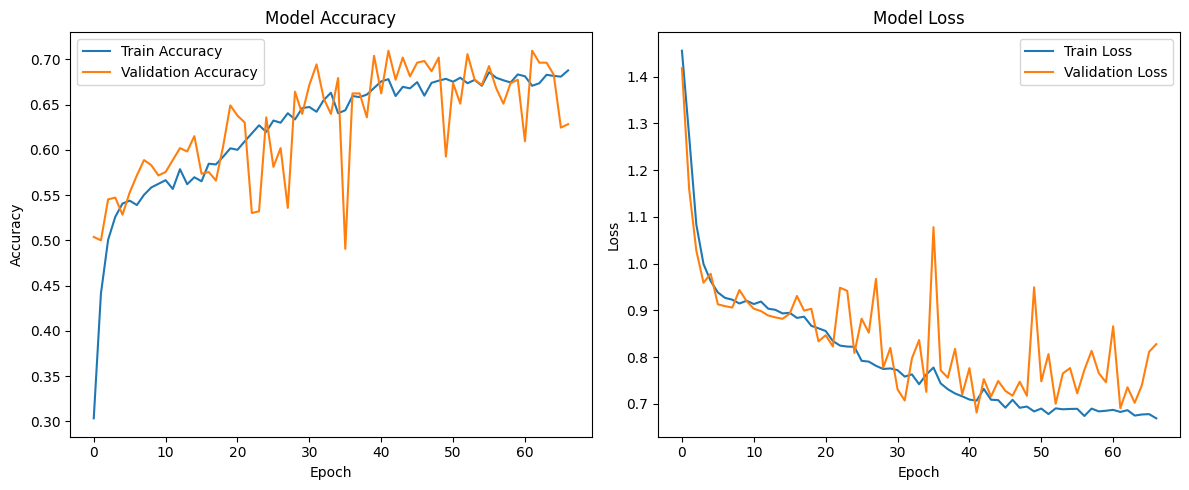

Miglior accuracy: 0.7094 (epoch 42)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.00      0.00      0.00        12
           C       0.57      0.66      0.61       141
           M       0.72      0.96      0.82        69
        None       0.95      0.96      0.96       156
           T       0.57      0.44      0.50       153

    accuracy                           0.71       531
   macro avg       0.56      0.60      0.58       531
weighted avg       0.69      0.71      0.69       531



c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

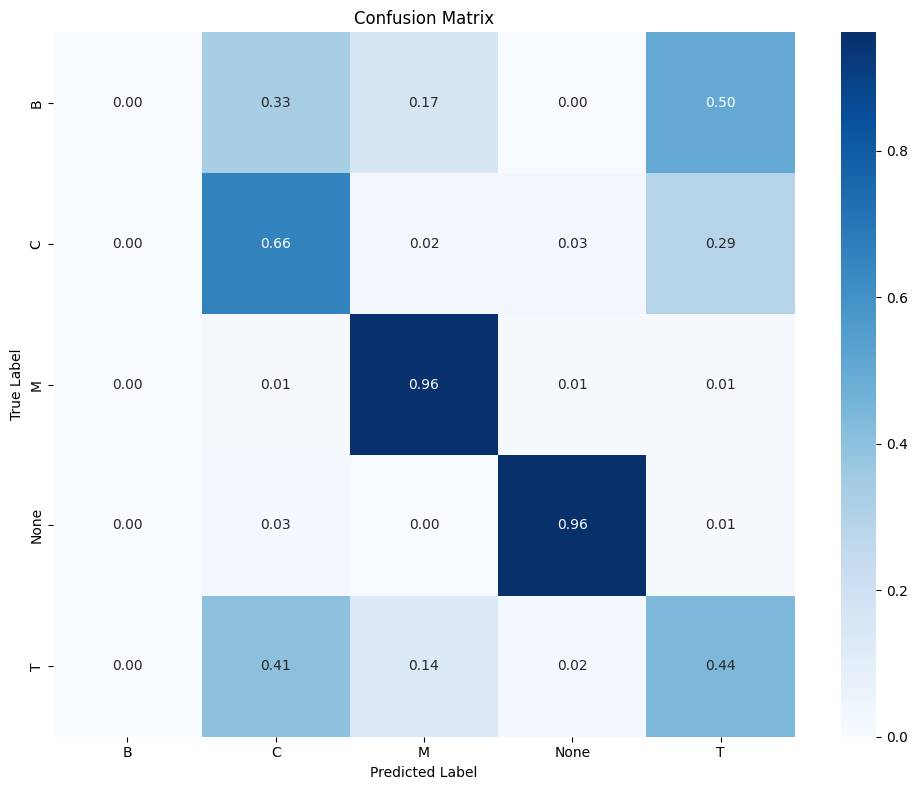

In [66]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_4, y_true_4, y_pred_4, class_names=le_vehicle.classes_)

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 5
# ------------------------------------------------------------------------------

'''
Come modello 1, ma con dataset bilanciato a max 1000 samples per classe

15 secondi a epoch

Decisamente meglio dei modelli più piccoli
Probabilmente con un early stopping più alto migliora andando avanti con tante epoch

Sbaglia ancora troppo le car, che confonde con i truck
'''

model_5 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_5.summary()


model_5.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_5.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 126, 186, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 91, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 43, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 19, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1024)           │       885,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537,525 (5.87 MB)

 Trainable params: 1,537,525 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train the model
history_5 = model_5.fit(X_train_bal_1000, y_train_vehicle_bal_1000,
                         validation_data=(X_val_bal_1000, y_val_vehicle_bal_1000),
                         epochs=150,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         verbose=1)

Epoch 1/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3565 - loss: 1.3827

78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.3574 - loss: 1.3807 - val_accuracy: 0.5321 - val_loss: 1.0131
Epoch 2/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.5672 - loss: 0.9012 - val_accuracy: 0.4849 - val_loss: 1.0493
Epoch 3/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6242 - loss: 0.7964

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6244 - loss: 0.7959 - val_accuracy: 0.6547 - val_loss: 0.9130
Epoch 4/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.6606 - loss: 0.7070 - val_accuracy: 0.4415 - val_loss: 1.1394
Epoch 5/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6873 - loss: 0.6657

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.6872 - loss: 0.6655 - val_accuracy: 0.6811 - val_loss: 0.8607
Epoch 6/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6846 - loss: 0.6069

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6846 - loss: 0.6071 - val_accuracy: 0.7151 - val_loss: 0.7689
Epoch 7/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7145 - loss: 0.5807

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7144 - loss: 0.5808 - val_accuracy: 0.7434 - val_loss: 0.6550
Epoch 8/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7368 - loss: 0.5821

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.7368 - loss: 0.5820 - val_accuracy: 0.7396 - val_loss: 0.5950
Epoch 9/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.7096 - loss: 0.5609 - val_accuracy: 0.7321 - val_loss: 0.6920
Epoch 10/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7089 - loss: 0.5536

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7092 - loss: 0.5534 - val_accuracy: 0.7792 - val_loss: 0.5775
Epoch 11/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7544 - loss: 0.4920

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7542 - loss: 0.4923 - val_accuracy: 0.7868 - val_loss: 0.5668
Epoch 12/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.7420 - loss: 0.5322 - val_accuracy: 0.6943 - val_loss: 0.6338
Epoch 13/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7633 - loss: 0.5071

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7633 - loss: 0.5070 - val_accuracy: 0.7717 - val_loss: 0.5112
Epoch 14/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7647 - loss: 0.5019

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.7645 - loss: 0.5019 - val_accuracy: 0.8151 - val_loss: 0.4952
Epoch 15/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.7580 - loss: 0.4912 - val_accuracy: 0.7623 - val_loss: 0.5574
Epoch 16/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7568 - loss: 0.5006

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7568 - loss: 0.5005 - val_accuracy: 0.7962 - val_loss: 0.4831
Epoch 17/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7659 - loss: 0.4864 - val_accuracy: 0.7208 - val_loss: 0.5279
Epoch 18/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.7847 - loss: 0.4562 - val_accuracy: 0.8000 - val_loss: 0.4998
Epoch 19/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7796 - loss: 0.4518 - val_accuracy: 0.7642 - val_loss: 0.5212
Epoch 20/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.7866 - loss: 0.4441 - val_accuracy: 0.7736 - val_loss: 0.5209
Epoch 21/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7945 - loss: 0.4671

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.7944 - loss: 0.4668 - val_accuracy: 0.7774 - val_loss: 0.4798
Epoch 22/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8044 - loss: 0.4249

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.8043 - loss: 0.4249 - val_accuracy: 0.8000 - val_loss: 0.4618
Epoch 23/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.7773 - loss: 0.4282 - val_accuracy: 0.7283 - val_loss: 0.5215
Epoch 24/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7761 - loss: 0.4890

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7762 - loss: 0.4886 - val_accuracy: 0.8094 - val_loss: 0.4467
Epoch 25/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.7907 - loss: 0.4266 - val_accuracy: 0.7113 - val_loss: 0.5378
Epoch 26/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.7989 - loss: 0.4115 - val_accuracy: 0.7302 - val_loss: 0.4943
Epoch 27/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.8134 - loss: 0.3983 - val_accuracy: 0.7547 - val_loss: 0.4918
Epoch 28/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8232 - loss: 0.4041 - val_accuracy: 0.7509 - val_loss: 0.5229
Epoch 29/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.8196 - loss: 0.3952 - val_accuracy: 0.7302 - val_loss: 0.5872
Epoch 30/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8274 - loss: 0.3896 - val_accuracy: 0.8094 - val_loss: 0.4631
Epoch 31/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8255 - loss: 0.3725 - val_a

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8286 - loss: 0.3771 - val_accuracy: 0.8151 - val_loss: 0.4000
Epoch 45/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.8427 - loss: 0.3288 - val_accuracy: 0.8038 - val_loss: 0.4567
Epoch 46/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8474 - loss: 0.3371 - val_accuracy: 0.8019 - val_loss: 0.4703
Epoch 47/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8488 - loss: 0.3335 - val_accuracy: 0.8170 - val_loss: 0.4720
Epoch 48/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8320 - loss: 0.3539 - val_accuracy: 0.7906 - val_loss: 0.5047
Epoch 49/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8561 - loss: 0.3270 - val_accuracy: 0.7547 - val_loss: 0.6255
Epoch 50/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8464 - loss: 0.3350 - val_accuracy: 0.8075 - val_loss: 0.5399
Epoch 51/150
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.8632 - loss: 0.3117 - val_a

In [70]:
# TEST
best_model_5 = tf.keras.models.load_model('best_model_5.h5')

test_loss_5, test_acc_5 = model_5.evaluate(X_test_bal_1000, y_test_vehicle_bal_1000, verbose=1)
print(f"\nTest accuracy: {test_acc_5:.4f}")
print(f"Test loss: {test_loss_5:.4f}")

y_pred_prob_5 = model_5.predict(X_test_bal_1000)
y_pred_5 = np.argmax(y_pred_prob_5, axis=1)
y_true_5 = np.argmax(y_test_vehicle_bal_1000, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8401 - loss: 0.4438

Test accuracy: 0.8117
Test loss: 0.4681
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


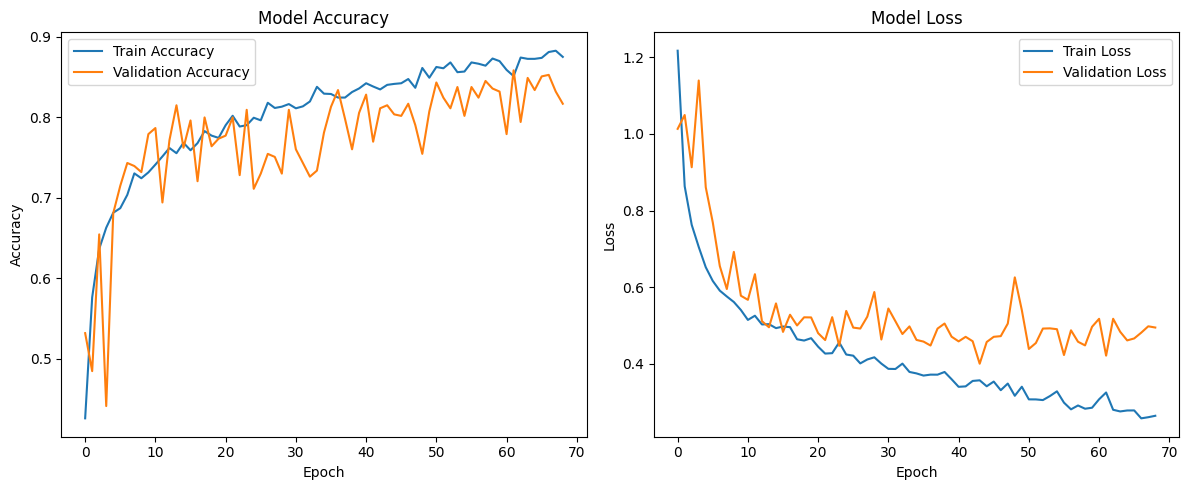

Miglior accuracy: 0.8585 (epoch 62)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.53      0.75      0.62        12
           C       0.74      0.61      0.67       141
           M       1.00      0.91      0.95        69
        None       0.96      0.99      0.97       156
           T       0.68      0.78      0.73       153

    accuracy                           0.81       531
   macro avg       0.78      0.81      0.79       531
weighted avg       0.82      0.81      0.81       531



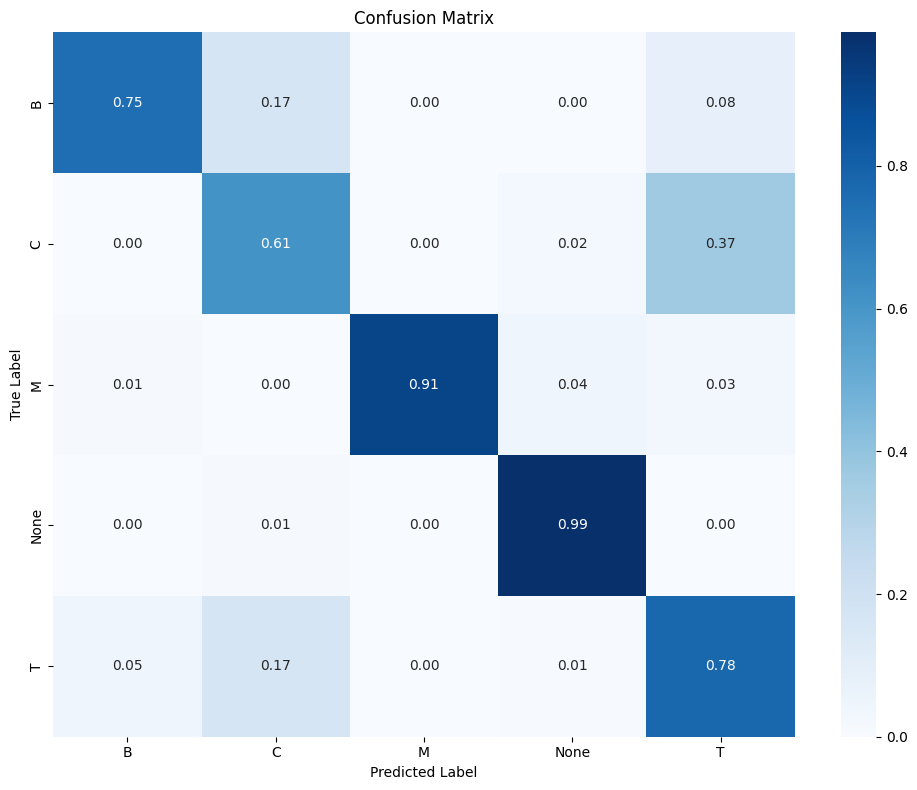

In [71]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_5, y_true_5, y_pred_5, class_names=le_vehicle.classes_)

Original class distribution: {'B': np.int64(106), 'C': np.int64(7804), 'M': np.int64(430), 'None': np.int64(8144), 'T': np.int64(1022)}
Target count per class: 3000
Balanced class distribution: {'B': np.int64(106), 'C': np.int64(3000), 'M': np.int64(430), 'None': np.int64(3000), 'T': np.int64(1022)}

Number of audio files per vehicle class (Original Full Dataset):
vehicle
None    8144
C       7804
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Full Dataset):
None    3000
C       3000
T       1022
M        430
B        106
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Training Set):
B         80
C       2070
M        305
None    2137
T        698
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Validation Set):
B        16
C       463
M        63
None    430
T       162
Name: count, dtype: int64

Number of audio files per vehicle class (Balanced Test Set):
B   

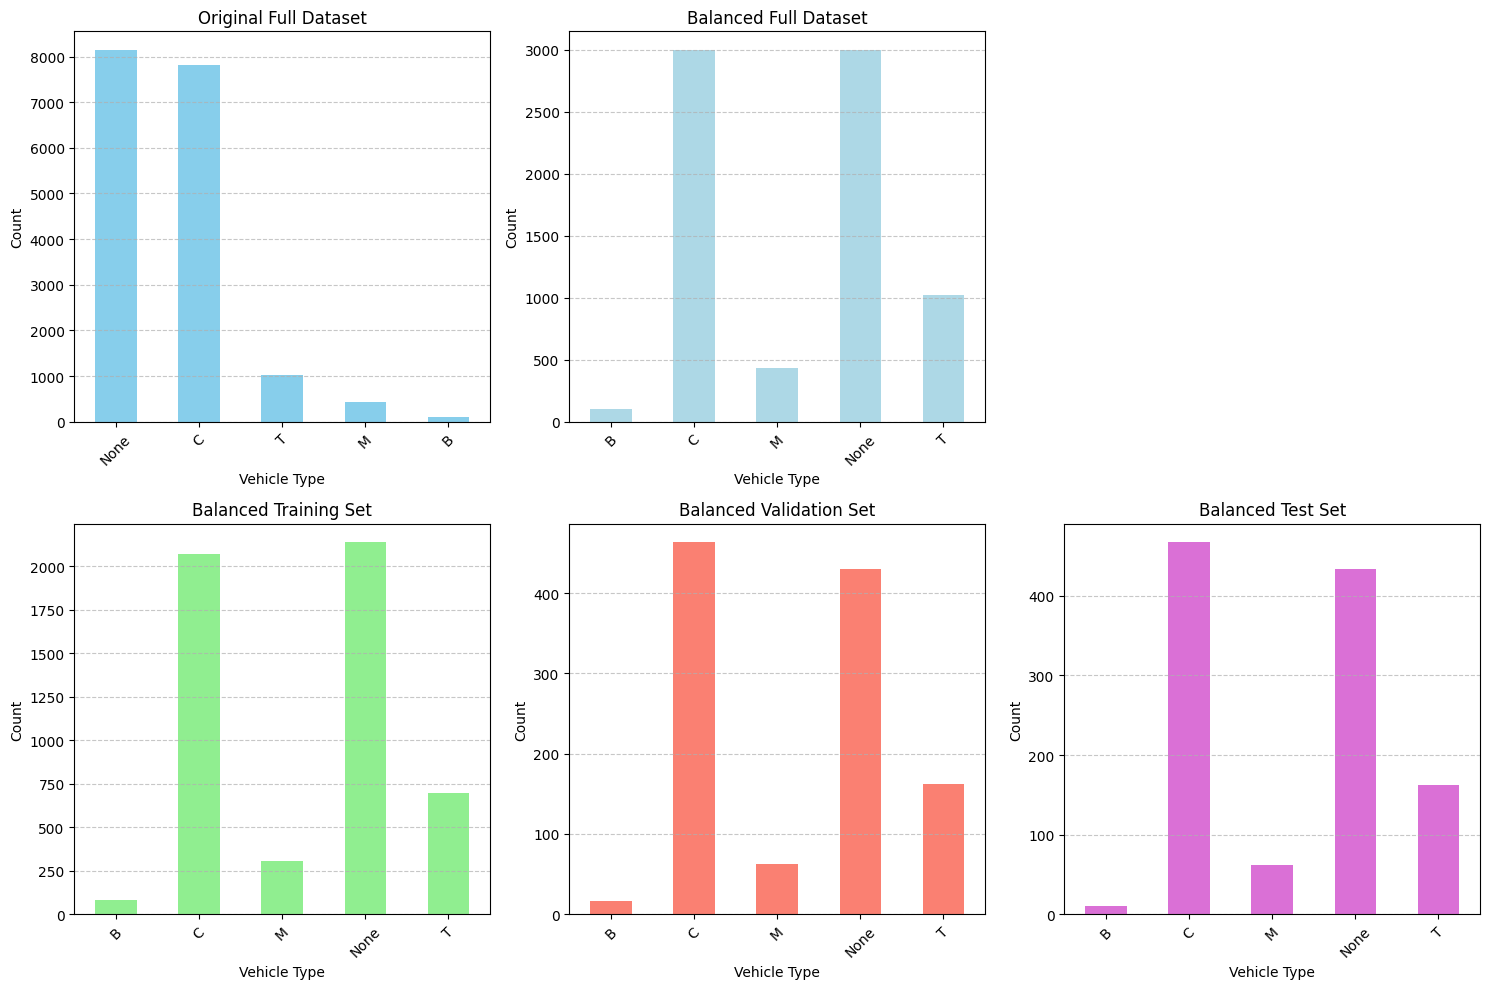

<Figure size 1200x600 with 0 Axes>

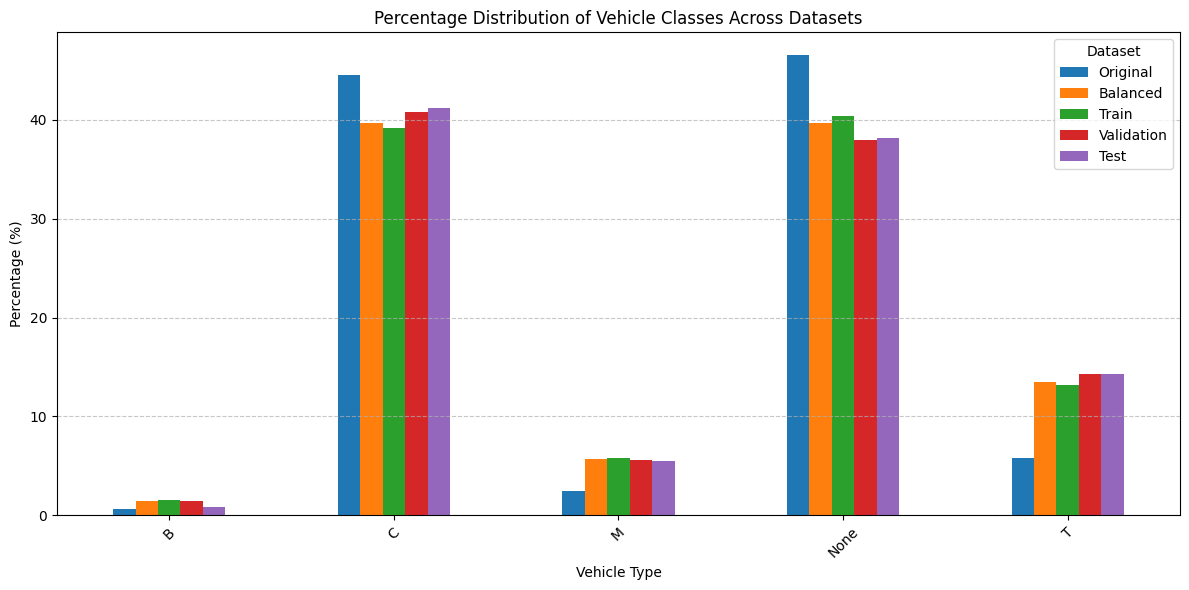

In [72]:
# Create balanced dataset
balanced_spectrograms_3000, balanced_vehicle_labels_3000, balanced_direction_labels_3000 = create_balanced_dataset(
    spectograms_reshaped, labels_cat_vehicles, labels_cat_direction,
    target_count = 3000
)

# Split the balanced dataset
# 1. First split: Train (70%) and Temporary (30%)
X_train_bal_3000, X_temp_bal_3000, y_train_vehicle_bal_3000, y_temp_vehicle_bal_3000, y_train_direction_bal_3000, y_temp_direction_bal_3000 = train_test_split(
    balanced_spectrograms_3000, 
    balanced_vehicle_labels_3000, 
    balanced_direction_labels_3000,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# 2. Second split: Temporary into Validation (15%) and Test (15%)
X_val_bal_3000, X_test_bal_3000, y_val_vehicle_bal_3000, y_test_vehicle_bal_3000, y_val_direction_bal_3000, y_test_direction_bal_3000 = train_test_split(
    X_temp_bal_3000,
    y_temp_vehicle_bal_3000, 
    y_temp_direction_bal_3000,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

# STAMPE

# 1. Count in the full dataset (original, unbalanced)
vehicle_counts_full = df_dataset["vehicle"].value_counts()
print("\nNumber of audio files per vehicle class (Original Full Dataset):")
print(vehicle_counts_full)

# Get the class distribution in the balanced dataset
balanced_vehicle_indices = np.argmax(balanced_vehicle_labels_3000, axis=1)
balanced_counts_full = pd.Series(balanced_vehicle_indices).map(lambda idx: le_vehicle.classes_[idx]).value_counts()
print("\nNumber of audio files per vehicle class (Balanced Full Dataset):")
print(balanced_counts_full)

# 2. Count in the balanced split datasets
# Convert one-hot encoded labels back to class indices
y_train_indices = np.argmax(y_train_vehicle_bal_3000, axis=1)
y_val_indices = np.argmax(y_val_vehicle_bal_3000, axis=1)
y_test_indices = np.argmax(y_test_vehicle_bal_3000, axis=1)

# Get the class names in the correct order
class_names = le_vehicle.classes_

# Create DataFrames for counting
train_counts = pd.Series(y_train_indices).map(lambda idx: class_names[idx]).value_counts()
val_counts = pd.Series(y_val_indices).map(lambda idx: class_names[idx]).value_counts()
test_counts = pd.Series(y_test_indices).map(lambda idx: class_names[idx]).value_counts()

# Ensure all classes are present in each count (even if zero)
for counts in [train_counts, val_counts, test_counts, balanced_counts_full]:
    for class_name in class_names:
        if class_name not in counts:
            counts[class_name] = 0
    counts.sort_index(inplace=True)

# Print counts for each split
print("\nNumber of audio files per vehicle class (Balanced Training Set):")
print(train_counts)
print("\nNumber of audio files per vehicle class (Balanced Validation Set):")
print(val_counts)
print("\nNumber of audio files per vehicle class (Balanced Test Set):")
print(test_counts)

# Visualize the class distribution
plt.figure(figsize=(15, 10))

# Original full dataset
plt.subplot(2, 3, 1)
vehicle_counts_full.plot(kind='bar', color='skyblue')
plt.title('Original Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced full dataset
plt.subplot(2, 3, 2)
balanced_counts_full.plot(kind='bar', color='lightblue')
plt.title('Balanced Full Dataset')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced training set
plt.subplot(2, 3, 4)
train_counts.plot(kind='bar', color='lightgreen')
plt.title('Balanced Training Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced validation set
plt.subplot(2, 3, 5)
val_counts.plot(kind='bar', color='salmon')
plt.title('Balanced Validation Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Balanced test set
plt.subplot(2, 3, 6)
test_counts.plot(kind='bar', color='orchid')
plt.title('Balanced Test Set')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a percentage distribution chart for comparison
plt.figure(figsize=(12, 6))

# Create a DataFrame with all counts for easy comparison
counts_df = pd.DataFrame({
    'Original': vehicle_counts_full / vehicle_counts_full.sum() * 100,
    'Balanced': balanced_counts_full / balanced_counts_full.sum() * 100,
    'Train': train_counts / train_counts.sum() * 100,
    'Validation': val_counts / val_counts.sum() * 100,
    'Test': test_counts / test_counts.sum() * 100
})

# Plot percentage distribution
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage Distribution of Vehicle Classes Across Datasets')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 6
# ------------------------------------------------------------------------------

'''
Come modello 1, ma con dataset bilanciato a max 3000 samples per classe

25 secondi a epoch

Prestazioni mi sembrano meglio rispetto al modello 5
Le car le becca, i truck 50%, bus 80%
'''

model_6 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_6.summary()


model_6.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_6.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 126, 186, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 61, 91, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 43, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 12, 19, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1024)           │       885,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537,525 (5.87 MB)

 Trainable params: 1,537,525 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Train the model
history_6 = model_6.fit(X_train_bal_3000, y_train_vehicle_bal_3000,
                         validation_data=(X_val_bal_3000, y_val_vehicle_bal_3000),
                         epochs=150,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         verbose=1)

Epoch 1/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5647 - loss: 1.0694

166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5654 - loss: 1.0681 - val_accuracy: 0.7628 - val_loss: 0.8029
Epoch 2/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.7722 - loss: 0.6040 - val_accuracy: 0.5979 - val_loss: 0.8960
Epoch 3/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.7985 - loss: 0.5467 - val_accuracy: 0.5794 - val_loss: 0.9259
Epoch 4/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8053 - loss: 0.5332

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8055 - loss: 0.5328 - val_accuracy: 0.8166 - val_loss: 0.5420
Epoch 5/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8224 - loss: 0.4569

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8224 - loss: 0.4568 - val_accuracy: 0.8219 - val_loss: 0.4951
Epoch 6/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.8347 - loss: 0.4441 - val_accuracy: 0.8148 - val_loss: 0.5028
Epoch 7/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8228 - loss: 0.4231

166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.8228 - loss: 0.4232 - val_accuracy: 0.8263 - val_loss: 0.4662
Epoch 8/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8295 - loss: 0.4276 - val_accuracy: 0.8307 - val_loss: 0.4667
Epoch 9/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8383 - loss: 0.3965 - val_accuracy: 0.8333 - val_loss: 0.4772
Epoch 10/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8480 - loss: 0.3769

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8481 - loss: 0.3769 - val_accuracy: 0.8510 - val_loss: 0.4325
Epoch 11/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8534 - loss: 0.3720

166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8533 - loss: 0.3720 - val_accuracy: 0.8466 - val_loss: 0.4074
Epoch 12/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8602 - loss: 0.3481

166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8601 - loss: 0.3483 - val_accuracy: 0.8483 - val_loss: 0.3956
Epoch 13/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8485 - loss: 0.3691

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8486 - loss: 0.3688 - val_accuracy: 0.8554 - val_loss: 0.3586
Epoch 14/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.8682 - loss: 0.3276 - val_accuracy: 0.8554 - val_loss: 0.3892
Epoch 15/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8639 - loss: 0.3339 - val_accuracy: 0.8651 - val_loss: 0.3932
Epoch 16/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.8711 - loss: 0.3155 - val_accuracy: 0.8642 - val_loss: 0.3867
Epoch 17/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.8609 - loss: 0.3219 - val_accuracy: 0.8660 - val_loss: 0.3712
Epoch 18/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.8736 - loss: 0.3113 - val_accuracy: 0.8219 - val_loss: 0.4162
Epoch 19/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8746 - loss: 0.2990

166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.8746 - loss: 0.2990 - val_accuracy: 0.8783 - val_loss: 0.3241
Epoch 20/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 149ms/step - accuracy: 0.8708 - loss: 0.3121 - val_accuracy: 0.8519 - val_loss: 0.3676
Epoch 21/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.8797 - loss: 0.2964 - val_accuracy: 0.7372 - val_loss: 0.4750
Epoch 22/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8753 - loss: 0.3082 - val_accuracy: 0.8554 - val_loss: 0.3631
Epoch 23/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.8773 - loss: 0.3001 - val_accuracy: 0.8536 - val_loss: 0.3812
Epoch 24/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.8813 - loss: 0.2949 - val_accuracy: 0.8545 - val_loss: 0.3666
Epoch 25/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8858 - loss: 0.2777

166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.8858 - loss: 0.2777 - val_accuracy: 0.8818 - val_loss: 0.3190
Epoch 26/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8865 - loss: 0.2797 - val_accuracy: 0.8668 - val_loss: 0.3296
Epoch 27/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.8889 - loss: 0.2690 - val_accuracy: 0.8325 - val_loss: 0.3728
Epoch 28/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.8918 - loss: 0.2661 - val_accuracy: 0.8660 - val_loss: 0.3219
Epoch 29/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.8922 - loss: 0.2681 - val_accuracy: 0.8413 - val_loss: 0.3686
Epoch 30/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.8848 - loss: 0.2730 - val_accuracy: 0.8721 - val_loss: 0.3229
Epoch 31/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.8932 - loss: 0.2599 - val_accuracy: 0.8801 - val_loss: 0.3244
Epoch 32/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.8962 - loss

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.8895 - loss: 0.2698 - val_accuracy: 0.8686 - val_loss: 0.3111
Epoch 35/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.8930 - loss: 0.2500 - val_accuracy: 0.8757 - val_loss: 0.3124
Epoch 36/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9016 - loss: 0.2490 - val_accuracy: 0.8845 - val_loss: 0.3358
Epoch 37/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.8984 - loss: 0.2463 - val_accuracy: 0.8686 - val_loss: 0.3326
Epoch 38/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9036 - loss: 0.2240 - val_accuracy: 0.8721 - val_loss: 0.3433
Epoch 39/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.8953 - loss: 0.2522 - val_accuracy: 0.8783 - val_loss: 0.3139
Epoch 40/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9079 - loss: 0.2298 - val_accuracy: 0.8642 - val_loss: 0.3466
Epoch 41/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9009 - loss:

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9009 - loss: 0.2420 - val_accuracy: 0.8871 - val_loss: 0.3043
Epoch 42/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9115 - loss: 0.2192 - val_accuracy: 0.8801 - val_loss: 0.3189
Epoch 43/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9016 - loss: 0.2265 - val_accuracy: 0.8845 - val_loss: 0.3065
Epoch 44/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9025 - loss: 0.2317 - val_accuracy: 0.8272 - val_loss: 0.4245
Epoch 45/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9103 - loss: 0.2159 - val_accuracy: 0.8757 - val_loss: 0.3329
Epoch 46/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9067 - loss: 0.2211 - val_accuracy: 0.8316 - val_loss: 0.4068
Epoch 47/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.8976 - loss: 0.2345 - val_accuracy: 0.8862 - val_loss: 0.3065
Epoch 48/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.9067 - loss

In [75]:
# TEST
best_model_6 = tf.keras.models.load_model('best_model_6.h5')

test_loss_6, test_acc_6 = model_6.evaluate(X_test_bal_3000, y_test_vehicle_bal_3000, verbose=1)
print(f"\nTest accuracy: {test_acc_6:.4f}")
print(f"Test loss: {test_loss_6:.4f}")

y_pred_prob_6 = model_6.predict(X_test_bal_3000)
y_pred_6 = np.argmax(y_pred_prob_6, axis=1)
y_true_6 = np.argmax(y_test_vehicle_bal_3000, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8901 - loss: 0.3009

Test accuracy: 0.8959
Test loss: 0.2968
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


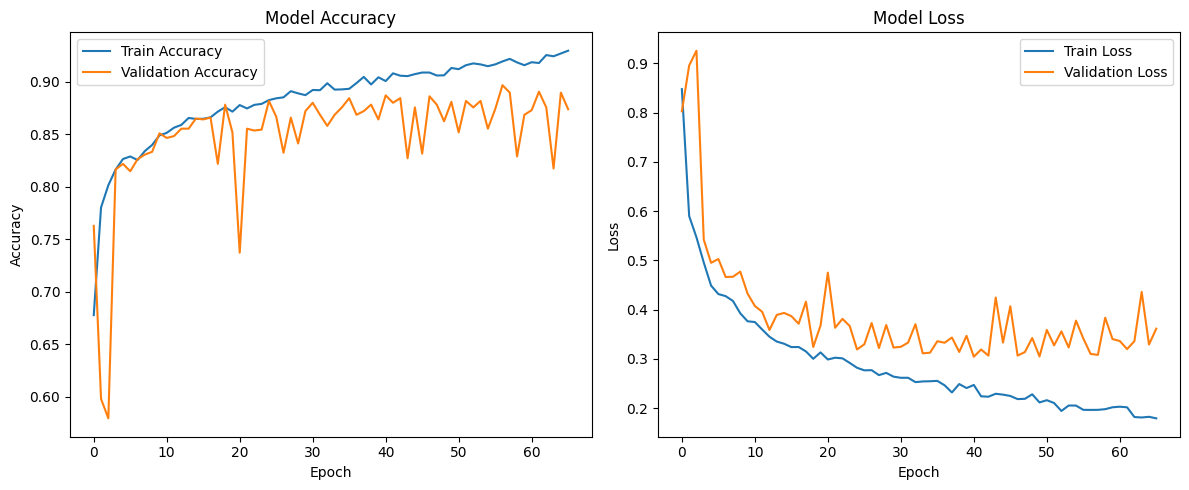

Miglior accuracy: 0.8968 (epoch 57)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.47      0.80      0.59        10
           C       0.84      0.94      0.89       467
           M       0.94      0.97      0.95        62
        None       0.99      0.99      0.99       433
           T       0.82      0.50      0.62       162

    accuracy                           0.90      1134
   macro avg       0.81      0.84      0.81      1134
weighted avg       0.90      0.90      0.89      1134



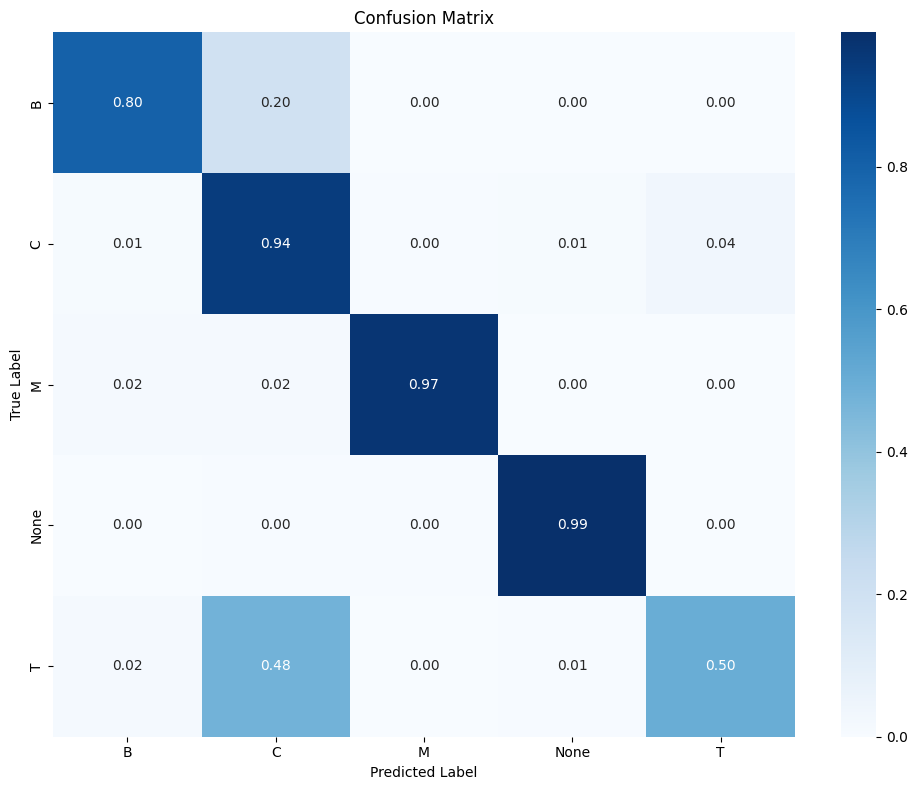

In [76]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_6, y_true_6, y_pred_6, class_names=le_vehicle.classes_)

In [ ]:
'''
class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.accuracy = self.add_weight(name='balanced_acc', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Converti in tensori d'indici
        y_true_indices = tf.argmax(y_true, axis=1)
        y_pred_indices = tf.argmax(y_pred, axis=1)
        
        # Funzione per calcolare la balanced accuracy su NumPy arrays
        def calc_balanced_acc(y_true, y_pred):
            # Converti i tensori in array numpy
            y_true_np = y_true.numpy()
            y_pred_np = y_pred.numpy()
            # Calcola e ritorna lo score come float32 scalare
            return np.float32(balanced_accuracy_score(y_true_np, y_pred_np))
        
        # Usa tf.py_function per eseguire operazioni NumPy
        score = tf.py_function(
            calc_balanced_acc, 
            [y_true_indices, y_pred_indices], 
            tf.float32
        )
        
        # Imposta la forma esplicitamente come tensore scalare
        score = tf.reshape(score, [])
        
        # Aggiorna lo stato della metrica
        self.accuracy.assign(score)
        
    def result(self):
        return self.accuracy
        
    def reset_state(self):
        self.accuracy.assign(0.0)
'''

In [ ]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 7
# ------------------------------------------------------------------------------

'''
Come modello 1, ma con dataset bilanciato a max 3000 samples per classe
e metriche aggiuntive e class weights

25 secondi a epoch


Forse peggio, più bilanciato, ma sbaglia un sacco di car
'''

model_7 = tf.keras.models.Sequential([
    tf.keras.Input(shape=spectograms_reshaped.shape[1:]),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(5, activation='softmax')
])

model_7.summary()


model_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(average='macro', name='f1_macro'),
        tf.keras.metrics.AUC(multi_label=True, curve='ROC', name='auc')
    ]
)
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_macro',  # Monitora F1 macro invece di val_loss
    patience=25,
    restore_best_weights=True,
    mode='max'  # Importante: per f1_score usiamo 'max' (diverso da 'min' della loss)
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_7.h5',
    monitor='val_f1_macro',  # Usa la stessa metrica dell'early stopping
    save_best_only=True,
    mode='max'   # Anche qui 'max' per l'F1
)


# Calcola i pesi in base all'inverso della frequenza
class_weights = {i: len(y_train_vehicle_bal_3000) / 
                   (np.sum(np.argmax(y_train_vehicle_bal_3000, axis=1) == i) * len(np.unique(np.argmax(y_train_vehicle_bal_3000, axis=1))))
                 for i in range(5)}

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 126, 186, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 63, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 61, 91, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 30, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 28, 43, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 14, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 12, 19, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 6, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1024)           │       885,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537,525 (5.87 MB)

 Trainable params: 1,537,525 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Train the model
history_7 = model_7.fit(X_train_bal_3000, y_train_vehicle_bal_3000,
                         validation_data=(X_val_bal_3000, y_val_vehicle_bal_3000),
                         epochs=150,
                         batch_size=32,
                         callbacks=[early_stopping, model_checkpoint],
                         class_weight=class_weights,
                         verbose=1)

Epoch 1/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2368 - auc: 0.5037 - f1_macro: 0.1377 - loss: 1.6287 - precision: 0.0000e+00 - recall: 0.0000e+00

166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.2379 - auc: 0.5037 - f1_macro: 0.1380 - loss: 1.6285 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4012 - val_auc: 0.5227 - val_f1_macro: 0.1860 - val_loss: 1.6025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4510 - auc: 0.7026 - f1_macro: 0.3023 - loss: 1.3996 - precision: 0.7716 - recall: 0.1695

166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.4514 - auc: 0.7034 - f1_macro: 0.3028 - loss: 1.3984 - precision: 0.7729 - recall: 0.1708 - val_accuracy: 0.4462 - val_auc: 0.8125 - val_f1_macro: 0.2958 - val_loss: 1.0422 - val_precision: 0.9874 - val_recall: 0.3457
Epoch 3/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.5844 - auc: 0.8315 - f1_macro: 0.4365 - loss: 1.1385 - precision: 0.9190 - recall: 0.3841 - val_accuracy: 0.4189 - val_auc: 0.7995 - val_f1_macro: 0.2357 - val_loss: 1.2206 - val_precision: 0.9810 - val_recall: 0.3642
Epoch 4/150
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6039 - auc: 0.8589 - f1_macro: 0.4859 - loss: 0.9658 - precision: 0.8976 - recall: 0.4488

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.6043 - auc: 0.8590 - f1_macro: 0.4863 - loss: 0.9654 - precision: 0.8976 - recall: 0.4491 - val_accuracy: 0.5944 - val_auc: 0.8821 - val_f1_macro: 0.5061 - val_loss: 0.8752 - val_precision: 0.9755 - val_recall: 0.3862
Epoch 5/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.6890 - auc: 0.8944 - f1_macro: 0.5604 - loss: 0.8189 - precision: 0.8640 - recall: 0.5410 - val_accuracy: 0.5494 - val_auc: 0.8902 - val_f1_macro: 0.4694 - val_loss: 0.9121 - val_precision: 0.9794 - val_recall: 0.3774
Epoch 6/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.7052 - auc: 0.8962 - f1_macro: 0.5900 - loss: 0.7465 - precision: 0.8046 - recall: 0.5619 - val_accuracy: 0.4356 - val_auc: 0.8603 - val_f1_macro: 0.3188 - val_loss: 1.1650 - val_precision: 0.8996 - val_recall: 0.3871
Epoch 7/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.6802 - auc: 0.9047 - f1_macro: 0.5704 - loss: 0.7499 - precision: 0.7858 - rec

166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.6931 - auc: 0.9101 - f1_macro: 0.5805 - loss: 0.6847 - precision: 0.8053 - recall: 0.5813 - val_accuracy: 0.6367 - val_auc: 0.9144 - val_f1_macro: 0.5387 - val_loss: 0.8734 - val_precision: 0.8642 - val_recall: 0.3986
Epoch 9/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.7074 - auc: 0.9152 - f1_macro: 0.5942 - loss: 0.7015 - precision: 0.7870 - recall: 0.6038 - val_accuracy: 0.4894 - val_auc: 0.8808 - val_f1_macro: 0.4225 - val_loss: 1.0144 - val_precision: 0.7234 - val_recall: 0.4012
Epoch 10/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7367 - auc: 0.9100 - f1_macro: 0.5933 - loss: 0.6952 - precision: 0.8303 - recall: 0.5952

166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7367 - auc: 0.9100 - f1_macro: 0.5934 - loss: 0.6950 - precision: 0.8302 - recall: 0.5954 - val_accuracy: 0.7698 - val_auc: 0.9352 - val_f1_macro: 0.6403 - val_loss: 0.5926 - val_precision: 0.8856 - val_recall: 0.6076
Epoch 11/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.7504 - auc: 0.9233 - f1_macro: 0.6301 - loss: 0.5891 - precision: 0.8157 - recall: 0.6678 - val_accuracy: 0.7222 - val_auc: 0.9298 - val_f1_macro: 0.6265 - val_loss: 0.6828 - val_precision: 0.8937 - val_recall: 0.4594
Epoch 12/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.7581 - auc: 0.9331 - f1_macro: 0.6494 - loss: 0.5829 - precision: 0.8227 - recall: 0.6868 - val_accuracy: 0.5688 - val_auc: 0.9212 - val_f1_macro: 0.5297 - val_loss: 0.7895 - val_precision: 0.7352 - val_recall: 0.4480
Epoch 13/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.7294 - auc: 0.9350 - f1_macro: 0.6435 - loss: 0.5742 - precision: 0.7767 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.7587 - auc: 0.9238 - f1_macro: 0.6455 - loss: 0.6273 - precision: 0.8172 - recall: 0.6641 - val_accuracy: 0.7434 - val_auc: 0.9394 - val_f1_macro: 0.6438 - val_loss: 0.6531 - val_precision: 0.9269 - val_recall: 0.4250
Epoch 15/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.7802 - auc: 0.9426 - f1_macro: 0.6864 - loss: 0.5279 - precision: 0.8265 - recall: 0.7262 - val_accuracy: 0.5564 - val_auc: 0.9217 - val_f1_macro: 0.4978 - val_loss: 0.8349 - val_precision: 0.9163 - val_recall: 0.3862
Epoch 16/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - accuracy: 0.7533 - auc: 0.9398 - f1_macro: 0.6848 - loss: 0.5620 - precision: 0.8164 - recall: 0.6787 - val_accuracy: 0.7654 - val_auc: 0.9368 - val_f1_macro: 0.6396 - val_loss: 0.6347 - val_precision: 0.9337 - val_recall: 0.4471
Epoch 17/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.7750 - auc: 0.9346 - f1_macro: 0.6842 - loss: 0.5406 - precision: 0.8138 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.7651 - auc: 0.9357 - f1_macro: 0.6846 - loss: 0.5203 - precision: 0.8093 - recall: 0.6978 - val_accuracy: 0.7099 - val_auc: 0.9475 - val_f1_macro: 0.6640 - val_loss: 0.5955 - val_precision: 0.8373 - val_recall: 0.5538
Epoch 20/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.7578 - auc: 0.9434 - f1_macro: 0.6683 - loss: 0.5359 - precision: 0.7858 - recall: 0.7238 - val_accuracy: 0.4991 - val_auc: 0.9064 - val_f1_macro: 0.4142 - val_loss: 0.9559 - val_precision: 0.6838 - val_recall: 0.4347
Epoch 21/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.7977 - auc: 0.9484 - f1_macro: 0.6963 - loss: 0.5031 - precision: 0.8468 - recall: 0.7163 - val_accuracy: 0.5414 - val_auc: 0.9221 - val_f1_macro: 0.4996 - val_loss: 0.8810 - val_precision: 0.7104 - val_recall: 0.4347
Epoch 22/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.7673 - auc: 0.9418 - f1_macro: 0.6728 - loss: 0.5082 - precision: 0.8145 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.7859 - auc: 0.9448 - f1_macro: 0.7114 - loss: 0.5077 - precision: 0.8247 - recall: 0.7259 - val_accuracy: 0.7787 - val_auc: 0.9395 - val_f1_macro: 0.6646 - val_loss: 0.6029 - val_precision: 0.9086 - val_recall: 0.4735
Epoch 25/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.8029 - auc: 0.9436 - f1_macro: 0.7006 - loss: 0.5146 - precision: 0.8379 - recall: 0.7547 - val_accuracy: 0.4912 - val_auc: 0.9125 - val_f1_macro: 0.4180 - val_loss: 1.0620 - val_precision: 0.5604 - val_recall: 0.4418
Epoch 26/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.7686 - auc: 0.9312 - f1_macro: 0.6647 - loss: 0.5781 - precision: 0.8247 - recall: 0.6668 - val_accuracy: 0.5476 - val_auc: 0.9334 - val_f1_macro: 0.4975 - val_loss: 0.8303 - val_precision: 0.5993 - val_recall: 0.4868
Epoch 27/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.7850 - auc: 0.9430 - f1_macro: 0.7002 - loss: 0.4659 - precision: 0.8129 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8101 - auc: 0.9523 - f1_macro: 0.7236 - loss: 0.4800 - precision: 0.8489 - recall: 0.7553 - val_accuracy: 0.7954 - val_auc: 0.9502 - val_f1_macro: 0.7079 - val_loss: 0.5348 - val_precision: 0.8756 - val_recall: 0.6949
Epoch 38/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8084 - auc: 0.9514 - f1_macro: 0.7330 - loss: 0.4097 - precision: 0.8267 - recall: 0.7825 - val_accuracy: 0.6429 - val_auc: 0.9453 - val_f1_macro: 0.5870 - val_loss: 0.7284 - val_precision: 0.7160 - val_recall: 0.4603
Epoch 39/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8144 - auc: 0.9534 - f1_macro: 0.7283 - loss: 0.4445 - precision: 0.8546 - recall: 0.7522 - val_accuracy: 0.6429 - val_auc: 0.9505 - val_f1_macro: 0.6069 - val_loss: 0.6588 - val_precision: 0.6670 - val_recall: 0.5952
Epoch 40/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.8064 - auc: 0.9502 - f1_macro: 0.7324 - loss: 0.4502 - precision: 0.8277 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.8531 - auc: 0.9635 - f1_macro: 0.7924 - loss: 0.3422 - precision: 0.8643 - recall: 0.8341 - val_accuracy: 0.8069 - val_auc: 0.9596 - val_f1_macro: 0.7625 - val_loss: 0.4501 - val_precision: 0.8235 - val_recall: 0.7857
Epoch 61/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8448 - auc: 0.9594 - f1_macro: 0.7545 - loss: 0.3989 - precision: 0.8651 - recall: 0.8178 - val_accuracy: 0.7337 - val_auc: 0.9584 - val_f1_macro: 0.6945 - val_loss: 0.5674 - val_precision: 0.7463 - val_recall: 0.7108
Epoch 62/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8320 - auc: 0.9627 - f1_macro: 0.7553 - loss: 0.3792 - precision: 0.8485 - recall: 0.8154 - val_accuracy: 0.7081 - val_auc: 0.9482 - val_f1_macro: 0.6830 - val_loss: 0.6189 - val_precision: 0.7232 - val_recall: 0.6728
Epoch 63/150
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.8290 - auc: 0.9659 - f1_macro: 0.7416 - loss: 0.3774 - precision: 0.8529 - 

In [90]:
# TEST
best_model_7 = tf.keras.models.load_model('best_model_7.h5')

# Il modello 7 ha metriche aggiuntive (accuracy, precision, recall, f1_macro, auc)
test_results = model_7.evaluate(X_test_bal_3000, y_test_vehicle_bal_3000, verbose=1)
test_loss_7 = test_results[0]
test_acc_7 = test_results[1]
test_prec_7 = test_results[2]
test_recall_7 = test_results[3]
test_f1_7 = test_results[4]
test_auc_7 = test_results[5]

print(f"\nTest accuracy: {test_acc_7:.4f}")
print(f"Test loss: {test_loss_7:.4f}")
print(f"Test precision: {test_prec_7:.4f}")
print(f"Test recall: {test_recall_7:.4f}")
print(f"Test F1 (macro): {test_f1_7:.4f}")
print(f"Test AUC: {test_auc_7:.4f}")

y_pred_prob_7 = model_7.predict(X_test_bal_3000)
y_pred_7 = np.argmax(y_pred_prob_7, axis=1)
y_true_7 = np.argmax(y_test_vehicle_bal_3000, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8291 - auc: 0.9473 - f1_macro: 0.7478 - loss: 0.3959 - precision: 0.8406 - recall: 0.8107

Test accuracy: 0.8236
Test loss: 0.4105
Test precision: 0.8379
Test recall: 0.8069
Test F1 (macro): 0.7576
Test AUC: 0.9506
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


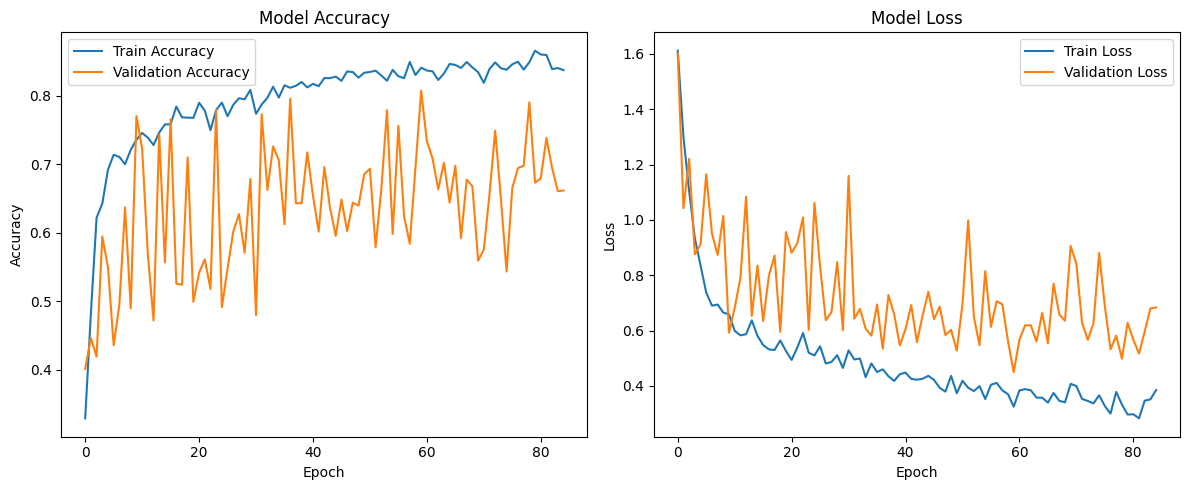

Miglior accuracy: 0.8069 (epoch 60)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.36      0.80      0.50        10
           C       0.88      0.69      0.78       467
           M       0.95      0.97      0.96        62
        None       0.99      0.98      0.98       433
           T       0.47      0.72      0.57       162

    accuracy                           0.82      1134
   macro avg       0.73      0.83      0.76      1134
weighted avg       0.86      0.82      0.83      1134



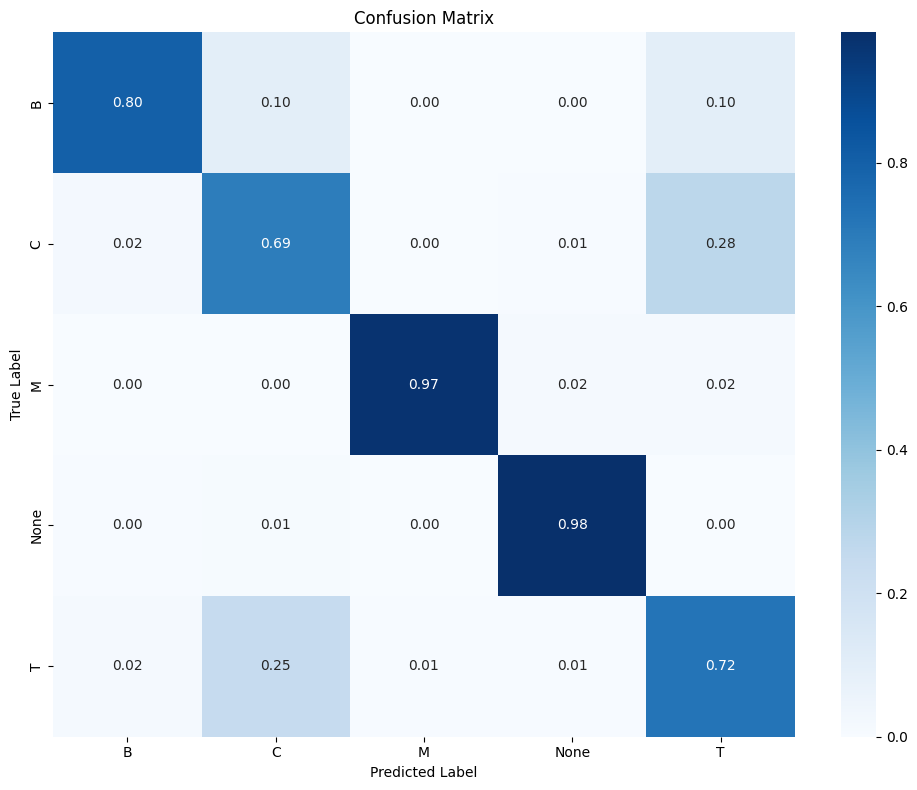

In [91]:
# STAMPE RISULTATI
plot_and_evaluate_single_output_model(history_7, y_true_7, y_pred_7, class_names=le_vehicle.classes_)